# Setup and data download

In [2]:
collab = True

In [3]:
if collab:
    ! pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 1.8 MB/s eta 0:00:00


In [21]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import tqdm
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

sns.set_style("whitegrid")
DARK_COL = "#6876a4"
LIGHT_COL = "#f0b64d"

In [10]:
######### Load fama french data ###########
ff = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3_daily.csv") if not collab else pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.csv")
ff = ff.rename({"Unnamed: 0": "Date"}, axis = 1)
ff["Date"] = pd.to_datetime(ff["Date"],  format="%Y%m%d")
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15036,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016
15037,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016
15038,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016
15039,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016


In [8]:
######### Get returns of S&P 500 stocks ###########

# Get tickers of S&P 500
def list_wikipedia_sp500() -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]

tickers = list(list_wikipedia_sp500().index) + ["^GSPC"]

# Download data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data = yf.download(tickers, start = start, end = end)
prices = data["Adj Close"].reset_index()
# Drop columns without any data
prices = prices.drop(["BF.B", "BRK.B", "HON"], axis=1)

# Compute log-prices and log-returns
returns = prices.copy()
returns.iloc[:,1:] = np.log(prices.iloc[:,1:])
Returns = np.diff(returns.iloc[:,1:],axis=0)*100  #times 100 so we get returns in percentage 
# We assume the first return to be 0
Returns = np.vstack((np.zeros(Returns.shape[1]),Returns))
returns.iloc[:,1:] = Returns
# Isolate S&P 500
sp500 = returns[["Date","^GSPC"]]
returns = returns.drop("^GSPC", axis = 1)
returns

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092242,10.724554,-0.596149,0.172748,NaN,-0.716055,-0.811205,-0.334110,0.616100,...,5.904160,-1.193039,0.389683,-1.195942,NaN,-0.342547,3.116528,-0.174548,3.465194,NaN
2,2010-01-06,-0.355888,-4.231382,0.868204,-1.603419,NaN,-0.950022,0.553768,-0.433244,1.057441,...,-1.320388,0.191854,0.860590,0.656682,NaN,-0.717456,-0.032311,-0.771667,8.338124,NaN
3,2010-01-07,-0.129771,2.904349,-0.024703,-0.185031,NaN,-1.616610,0.825017,-0.589966,-0.093495,...,2.113141,-0.432224,-0.314641,1.300503,NaN,-0.028811,2.268120,-2.531778,10.616030,NaN
4,2010-01-08,-0.032462,-1.926850,0.394482,0.662601,NaN,1.080618,0.509940,-0.197437,-0.398598,...,-0.719105,0.048148,-0.401992,0.000000,NaN,0.028811,-2.122823,-0.325557,-1.631961,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


In [11]:
# Merge dataframes based on date
df = pd.merge(ff, returns, on = "Date", how = "inner", suffixes=["_FF", ""])
df

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,1.69,0.79,1.13,-0.17,0.21,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,0.31,-0.41,1.24,-0.19,0.19,0.000,-1.092242,10.724554,-0.596149,...,5.904160,-1.193039,0.389683,-1.195942,NaN,-0.342547,3.116528,-0.174548,3.465194,NaN
2,2010-01-06,0.13,-0.13,0.57,-0.05,0.20,0.000,-0.355888,-4.231382,0.868204,...,-1.320388,0.191854,0.860590,0.656682,NaN,-0.717456,-0.032311,-0.771667,8.338124,NaN
3,2010-01-07,0.40,0.25,0.98,-0.69,0.22,0.000,-0.129771,2.904349,-0.024703,...,2.113141,-0.432224,-0.314641,1.300503,NaN,-0.028811,2.268120,-2.531778,10.616030,NaN
4,2010-01-08,0.33,0.32,0.01,0.22,-0.37,0.000,-0.032462,-1.926850,0.394482,...,-0.719105,0.048148,-0.401992,0.000000,NaN,0.028811,-2.122823,-0.325557,-1.631961,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016,0.837650,1.590773,3.467113,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016,-0.331202,0.286533,0.867762,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016,0.915649,2.612226,1.551751,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016,0.477010,0.832759,0.897704,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


# 1. Do a regression using the Fama french factors for each stock excess returns and store the estimated coefficients, their t-statistics, and the R squared in a 500 x 13 matrix.

In [12]:
def prepare_data_ols(df):
    """
    Function that prepares the data for OLS and adds a constant.
    """
    ff_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA_FF"]
    X = df[ff_columns]
    X = sm.add_constant(X)
    return X

X = prepare_data_ols(df)
X

,const,Mkt-RF,SMB,HML,RMW,CMA_FF
0,1.0,1.69,0.79,1.13,-0.17,0.21
1,1.0,0.31,-0.41,1.24,-0.19,0.19
2,1.0,0.13,-0.13,0.57,-0.05,0.20
3,1.0,0.40,0.25,0.98,-0.69,0.22
4,1.0,0.33,0.32,0.01,0.22,-0.37
...,...,...,...,...,...,...
3329,1.0,0.27,0.51,1.02,-0.28,0.35
3330,1.0,-0.17,-0.03,0.74,0.08,0.55
3331,1.0,1.39,-0.34,-0.50,-0.90,-0.54
3332,1.0,0.51,-0.61,-0.59,0.20,-0.09


In [13]:
def ols_estimation(df, X, returns, forecast = False):
    """
    Function that estimates OLS-coefficients for every stock
    """
    X_ = X.copy()
    beta_names = [f"beta_{var}" for var in X.columns]
    tvalue_names = [f"t_{var}" for var in X.columns]
    stocks = returns.columns[1:] # Excludes Date
    df_ols_results = pd.DataFrame(np.zeros((len(stocks), 13+1)), columns = ["stock"] + beta_names + tvalue_names + ["R2"])

    if forecast:
        X_ = X_[:-1].reset_index(drop = True)


    for i, stock in enumerate(stocks):
        # Get dependent variable y: excess returns of stock (X stays the same for every stock)
        y = df[stock] - df["RF_FF"]
        if forecast:
            y = y[1:].reset_index(drop = True)
        
        ols = sm.OLS(endog=y, exog=X_, missing = "drop")
        ols_results = ols.fit()
        coefs = ols_results.params
        t_stats = ols_results.tvalues
        r2 = ols_results.rsquared
        df_ols_results.iloc[i, 0] = stock
        df_ols_results.iloc[i, 1:] = np.concatenate([coefs,t_stats,[r2]])
    
    return df_ols_results


df_ols_results = ols_estimation(df, X, returns)
df_ols_results.head()

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,-0.002305,1.147960,0.042656,-0.177299,-0.233549,0.126153,-0.109379,57.002633,1.119670,-4.897132,-4.606571,1.814016,0.555602
1,AAL,-0.026688,1.273091,0.834769,0.770071,0.242064,-0.354722,-0.558791,27.894753,9.668785,9.385571,2.106804,-2.250750,0.302043
2,AAP,-0.015915,0.842018,0.328666,0.037590,0.583783,0.039670,-0.533398,29.532900,6.093710,0.733375,8.133300,0.402922,0.250085
3,AAPL,0.025276,1.178569,-0.175438,-0.497187,0.595588,-0.023428,1.187734,57.955255,-4.560415,-13.599534,11.633600,-0.333615,0.539743
4,ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368702,0.967088,28.303824,-2.715761,-2.667288,1.187548,3.975085,0.245479


# 2. Compute descriptive statistics for each of the 13 columns of the previous question.

In [12]:
# Get discriptive statistics of dataframe
df_ols_results.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001069,0.999384,0.140281,0.177711,0.089968,0.003838,-0.085020,42.773848,2.086165,4.501408,2.099550,0.440163,0.429732
std,0.033114,0.216046,0.299802,0.498196,0.324850,0.426940,0.924740,12.759228,6.125265,12.265235,5.324297,5.450592,0.134704
min,-0.086930,0.440068,-0.548381,-0.920035,-1.137032,-1.556368,-2.743256,2.348171,-15.501227,-16.779481,-19.895189,-17.911647,0.058644
25%,-0.016873,0.847333,-0.097875,-0.164749,-0.062510,-0.215519,-0.698179,34.721987,-2.327997,-4.124555,-1.062629,-2.495676,0.331104
50%,-0.001784,1.001999,0.109268,0.097894,0.148759,0.058548,-0.079938,41.245234,2.524025,2.320304,2.278892,0.685815,0.426387
75%,0.012642,1.146461,0.336664,0.388927,0.324796,0.290819,0.532678,50.602795,6.652109,8.613367,6.168714,3.649558,0.522387
max,0.324966,1.675626,1.357604,1.807275,0.888307,0.971784,2.458253,83.367576,17.323131,52.439317,14.599543,14.323295,0.783297


# 3. Compute nonparametric density estimates for each of the 13 t-statistics (you have about 500 values for each statistic) and make plots. Comment.

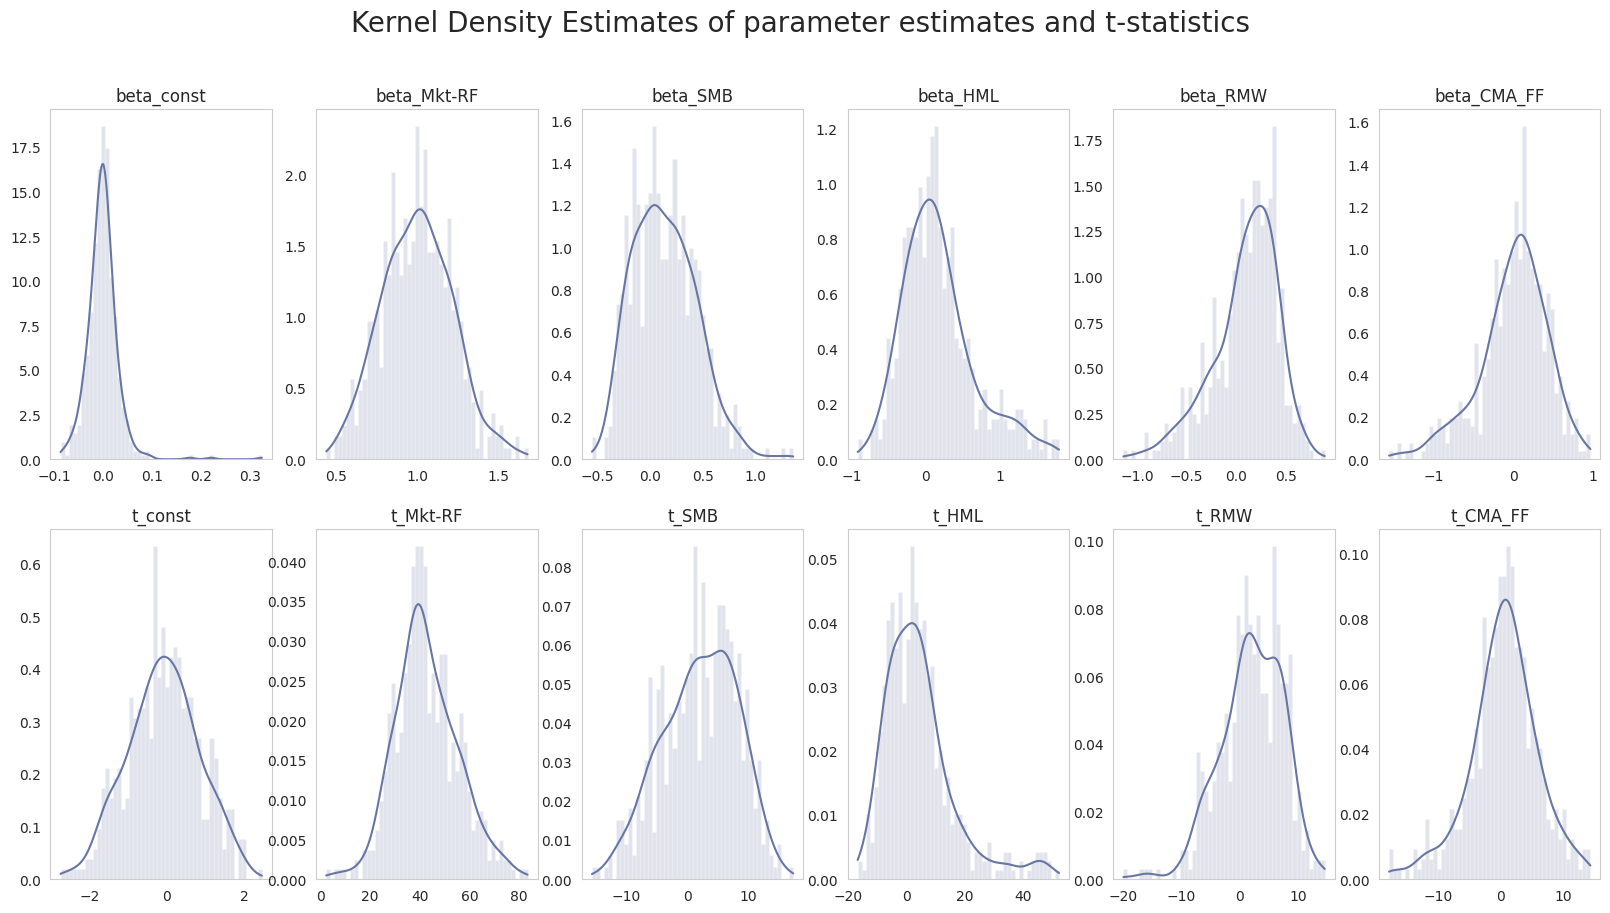

In [13]:
def kde_statistics(df_ols_results, df_ols_results2 = None, label1 = "daily", label2 = "monthly"):
    """
    Create Kernel density estimates and histograms of estimate and every t-statistic
    """
    fig, axs = plt.subplots(2, 6, figsize = (20, 10))
    axs = axs.reshape(-1)
    colnames = df_ols_results.columns[1:]

    for i, ax in enumerate(axs):
        if i >= len(colnames):
            break
        vals = df_ols_results.iloc[:,1+i]
        d = stats.gaussian_kde(vals)
        ind = np.linspace(min(vals),max(vals),500)
        kdepdf = d.evaluate(ind)
        ax.plot(ind, kdepdf, label=label1, color = DARK_COL)
        ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
        ax.grid(False)
        ax.set_title(colnames[i])
        if not df_ols_results2 is None:
            vals = df_ols_results2.iloc[:,1+i]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals),max(vals),500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label=label2, color = LIGHT_COL, ls = "--")
            ax.legend()
            ax.hist(vals, density = True, bins = 50, color = LIGHT_COL, alpha = 0.2)
    plt.suptitle("Kernel Density Estimates of parameter estimates and t-statistics", size = 20)
    plt.show()

kde_statistics(df_ols_results)

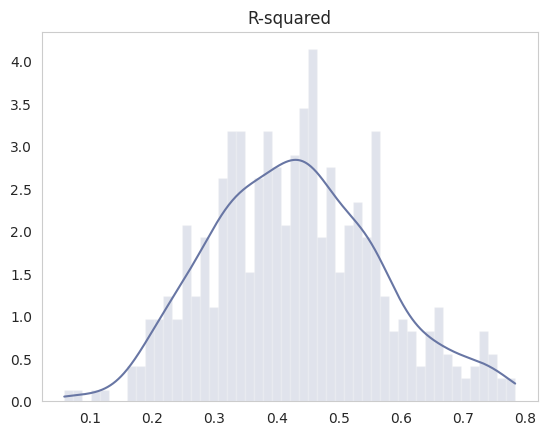

In [14]:
def plot_r_squared(df_ols_results, df_ols_results_monthly = None, label1 = "daily", label2 = "monthly"):
    """
    Function that plots R-squared
    """
    vals = df_ols_results["R2"]
    d = stats.gaussian_kde(vals)
    ind = np.linspace(min(vals),max(vals),500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label=label1, color = DARK_COL)
    plt.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
    if not df_ols_results_monthly is None:
        vals = df_ols_results_monthly["R2"]
        d = stats.gaussian_kde(vals)
        ind = np.linspace(min(vals),max(vals),500)
        kdepdf = d.evaluate(ind)
        plt.plot(ind, kdepdf, label=label2, color = LIGHT_COL, ls = "--")
        plt.hist(vals, density = True, bins = 50, color = LIGHT_COL, alpha = 0.2)
        plt.legend()
    plt.grid(False)
    plt.title("R-squared")
    plt.show()

plot_r_squared(df_ols_results)

**Comment:** From these plots we can make the following observations.

First of all, a lot of the coefficient estimates of the FF-factors seem to statistically significant. The factor that is clearly the most important is $R_m - R_f$, with the t-statistic distribution having a mean of around 40. This means that in almost all cases the market factor has a positive impact on the stock returns. Furthermore we observe that the t-statistics are generally greater (in absolute value) than 1.96, which means that we reject the hypothesis that the factors have no impact on the excess returns. Indeed, the t-statistics for SMB, HML, RMW and CMA have a large range (on average -15 to 15) with a distribution that is fairly normal.

In fact we observe that most parameter estimates seem to be relatively normally distributed, with the exception of HML and RMW, which have a parameter distribution that is skewed to the right and left respectively. Since the corresponding t-statistics are merely a scaled version of the parameter estimates, it is not surprising that most t-statistics are normally distributed as well.

The R-squared distribution estimate looks fairly normal, with a mean of around 0.4. That indicates that the FF-factors can explain (on average) 40% of the total variance of excess returns.

# 4. How differ the estimated factor coefficients according to the 11 sectors of the Global Industry Classification Standard?

In [26]:
def add_sector(df):
    """
    Function that adds a sector column to a dataframe using yfinance
    """
    df = df.copy()
    stocks = df["stock"]
    df["sector"] = ""
    for i, stock in enumerate(tqdm.tqdm(stocks)):
        ticker = yf.Ticker(stock)
        try:
            sector = ticker.get_info()["sector"]
        except KeyError:
            print(f"No sector found for {stock}")
        df.iloc[i, -1] = sector
    return df

In [27]:
df_results_sector = add_sector(df_ols_results)

 16%|█▌        | 80/500 [00:09<00:47,  8.79it/s]

No sector found for CAT


100%|██████████| 500/500 [01:02<00:00,  8.06it/s]


In [17]:
def plot_violin_sector(df, df2 = None):
    """
    Plots violin plots to show distributions of coefficients and t-statistics for all 11 sectors.
    """
    monthly_daily = False
    if not df2 is None:
        monthly_daily = True
    sns.set_style("whitegrid")
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15), sharey=True, squeeze=True)
    #plt.close('all')
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    

    for i, ax in enumerate(axs):
        D = pd.pivot(df[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
        ax = sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, inner = None if monthly_daily else "box", orient = "h", ax=ax, color = "grey" if monthly_daily else None)
        
        if not df2 is None:
            D = pd.pivot(df2[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
            ax = sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, inner = None, linewidth=5, orient = "h", ax=ax)
            
            for violin in ax.collections:
                violin.set_alpha(0.2)
            fig.suptitle("Difference daily (thin lines) vs. monthly (thick lines)", fontsize=20)
        ax.set_ylabel("")
        ax.grid(False)
        ax.set_title(coef_names[i])
    plt.tight_layout()
    


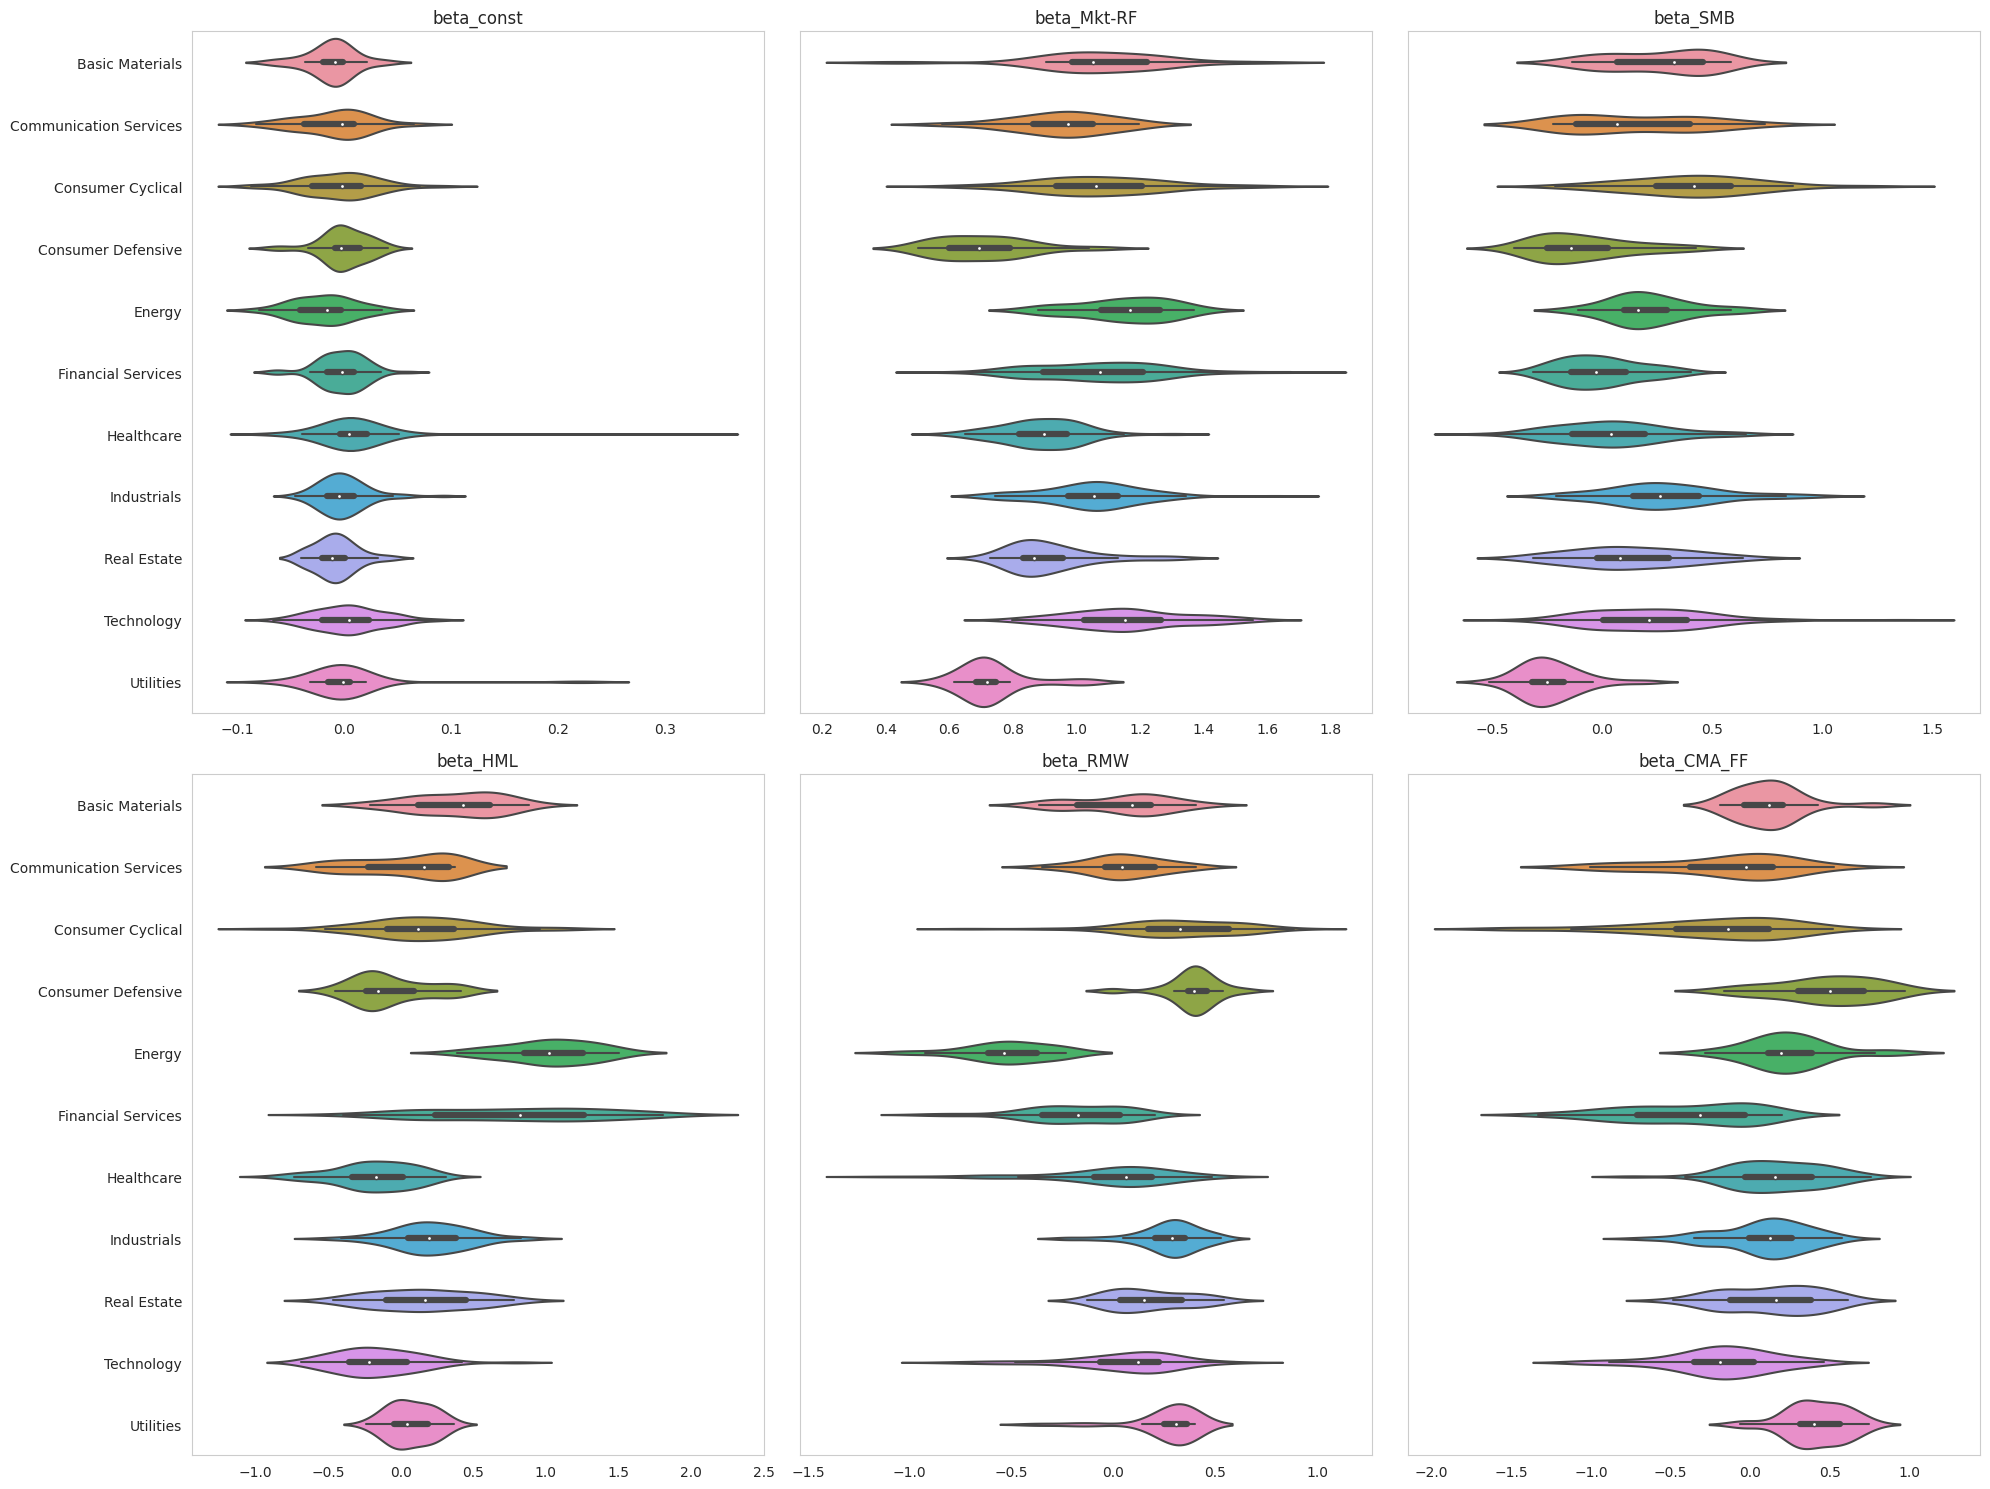

In [18]:
plot_violin_sector(df_results_sector)

**Comment** 

In these plots we can observe the distribution of the distribution of each coefficient for every sector. For the constant we do not observe a considerable difference. That being said, for the other coefficients, we observe differences among all sectors. For instance, for the market factor, we see that consumer cyclical and utilies are less influenced by the market, whereas sectors like Energy and Technology are heavily market-influenced with an average coefficient above 1. That being said, we observe that all sectors are positively influenced by the market.

Let's focus on the utilies sector in particular and 

In [19]:
def plot_kde_sector(df):
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15))
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    sns.set_style("whitegrid")


    for sector in df["sector"].unique():
        df_sector = df_ols_results[df["sector"] == sector]
        for i, ax in enumerate(axs):
            vals = df_sector.iloc[:,i+1]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals)-0.2,max(vals) + 0.3,500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label=sector)
            ax.legend()
            ax.grid(False)
            ax.set_title(coef_names[i])

# 5. Is it possible to cluster the stocks in groups in an unsupervised way? How many clusters do you recommend and what are typical characteristics of each cluster.

For the clustering we tried three different approaches:
1. Clustering based on FF-OLS-coefficients (**Best approach**)
2. Clustering based on Fourier coefficients extracted from the returns time series
3. Clustering based on raw time series using eucledian distance

We decided to go with the first approach, as it allows for **clearly distinct clusters** and **better interpretability**. We kept the three approaches in the notebook, but we will only comment the first approach. For all three methods we used hierarchical clustering, as it allows to plot a dendrogram, which allows to determine the right amount of clusters visually.

## Best approach: Clustering based on FF-coefficients
- Best approach: Interpretability & clear clusters

In [14]:
def prep_cluster_ff_coefs(df_ols_results):
    """
    Cleans dataframe for clustering.
    """
    df_ff_clustering = df_ols_results.copy()
    cols_of_interest = df_ols_results.columns[:13]
    df_ff_clustering = df_ff_clustering[cols_of_interest]
    df_ff_clustering.index = df_ff_clustering["stock"].values
    df_ff_clustering = df_ff_clustering.drop("stock", axis = 1)
    return df_ff_clustering

df_ff_clustering = prep_cluster_ff_coefs(df_ols_results)
df_ff_clustering

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF
A,-0.002305,1.147960,0.042656,-0.177299,-0.233549,0.126153,-0.109379,57.002633,1.119670,-4.897132,-4.606571,1.814016
AAL,-0.026688,1.273091,0.834769,0.770071,0.242064,-0.354722,-0.558791,27.894753,9.668785,9.385571,2.106804,-2.250750
AAP,-0.015915,0.842018,0.328666,0.037590,0.583783,0.039670,-0.533398,29.532900,6.093710,0.733375,8.133300,0.402922
AAPL,0.025276,1.178569,-0.175438,-0.497187,0.595588,-0.023428,1.187734,57.955255,-4.560415,-13.599534,11.633600,-0.333615
ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368702,0.967088,28.303824,-2.715761,-2.667288,1.187548,3.975085
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.007844,0.855561,-0.030755,0.042027,0.327988,0.066488,0.371543,42.407810,-0.805847,1.158755,6.457780,0.954360
ZBH,-0.018393,0.860477,0.193156,0.166984,0.117461,-0.168360,-0.829153,40.593159,4.816872,4.381815,2.201098,-2.300006
ZBRA,0.005819,1.202005,0.416916,-0.265489,0.188217,-0.103430,0.193632,41.857025,7.674556,-5.142510,2.603470,-1.043000
ZION,-0.003125,1.049921,0.337521,1.631795,-0.552389,-0.945909,-0.130748,45.974116,7.812678,39.745621,-9.607994,-11.994493


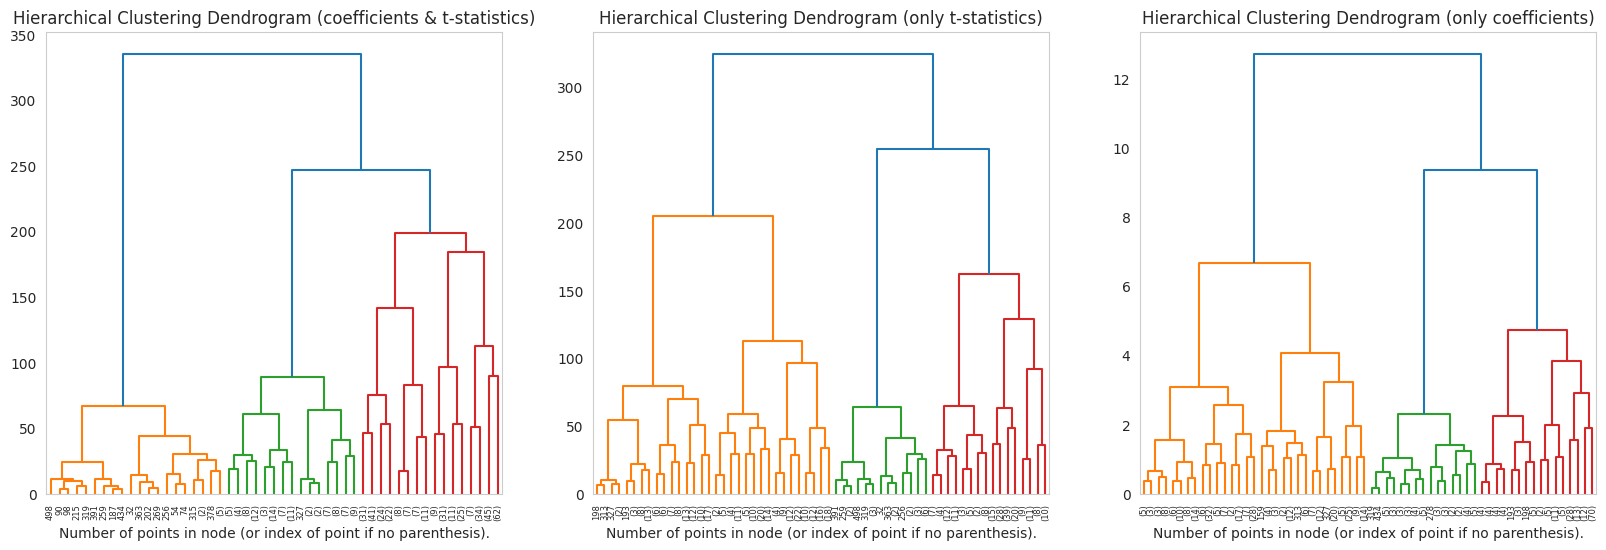

In [21]:
def plot_dendrogram(model, **kwargs):
    """
    Plots dendrogram for a given clustering model
    """
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def plot_dendrogram_ff(df_ols_results, p = 5):
    """
    Function that compares three different approaches using hierachical clustering
    using eucledian distance.
    """
    colranges = [(1, 13), (6,12), (1,6)]
    titles = ["(coefficients & t-statistics)", "(only t-statistics)", "(only coefficients)"]
    fig, axs = plt.subplots(1, 3, figsize = (20, 6))
    sns.set_style("whitegrid")
    for i, (ax, (col_min, col_max)) in enumerate(zip(axs,colranges)):
        df_ff_clustering = df_ols_results.copy()
        cols_of_interest = df_ols_results.columns[col_min:col_max]
        df_ff_clustering = df_ff_clustering[cols_of_interest]

        # setting distance_threshold=0 ensures we compute the full tree.
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

        model = model.fit(df_ff_clustering)
        ax.set_title(f"Hierarchical Clustering Dendrogram {titles[i]}")
        # plot the top three levels of the dendrogram
        plot_dendrogram(model, truncate_mode="level", p=p, ax= ax)
        ax.grid(False)
        ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

plot_dendrogram_ff(df_ols_results)

The methodology to choose the amount of clusters is th following: we imagine a horizontal line that slices the tree in two where the vertical lines are the longest. The number of lines being cut determines the number of clusters. From these dendrograms we can see that we by using **only t-statistics** we are able to separate stocks into **6 distinct clusters**. We will now see how these clusters differ and what characteristics each cluster has.

In [36]:
# Fit the model
df_ff_clustering = df_ols_results.iloc[:,1:].copy()
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(df_ff_clustering)

In [37]:
# Get clusters and append it to ols results
df_clustering_result = df_ols_results.copy()
df_clustering_result["cluster"] = model.labels_ + 1
df_clustering_result = df_clustering_result.set_index("stock")

In [38]:
df_clustering_result

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2,cluster
stock,,,,,,,,,,,,,,
A,-0.002305,1.147960,0.042656,-0.177299,-0.233549,0.126153,-0.109379,57.002633,1.119670,-4.897132,-4.606571,1.814016,0.555602,2
AAL,-0.026688,1.273091,0.834769,0.770071,0.242064,-0.354722,-0.558791,27.894753,9.668785,9.385571,2.106804,-2.250750,0.302043,3
AAP,-0.015915,0.842018,0.328666,0.037590,0.583783,0.039670,-0.533398,29.532900,6.093710,0.733375,8.133300,0.402922,0.250085,6
AAPL,0.025276,1.178569,-0.175438,-0.497187,0.595588,-0.023428,1.187734,57.955255,-4.560415,-13.599534,11.633600,-0.333615,0.539743,2
ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368702,0.967088,28.303824,-2.715761,-2.667288,1.187548,3.975085,0.245479,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.007844,0.855561,-0.030755,0.042027,0.327988,0.066488,0.371543,42.407810,-0.805847,1.158755,6.457780,0.954360,0.377465,1
ZBH,-0.018393,0.860477,0.193156,0.166984,0.117461,-0.168360,-0.829153,40.593159,4.816872,4.381815,2.201098,-2.300006,0.398804,6
ZBRA,0.005819,1.202005,0.416916,-0.265489,0.188217,-0.103430,0.193632,41.857025,7.674556,-5.142510,2.603470,-1.043000,0.416724,1


### Typical features of each cluster

In [39]:
sector_cluster = pd.merge(df_results_sector[["stock", "sector"]].set_index("stock"), df_clustering_result, on = "stock")[["sector", "cluster"]]

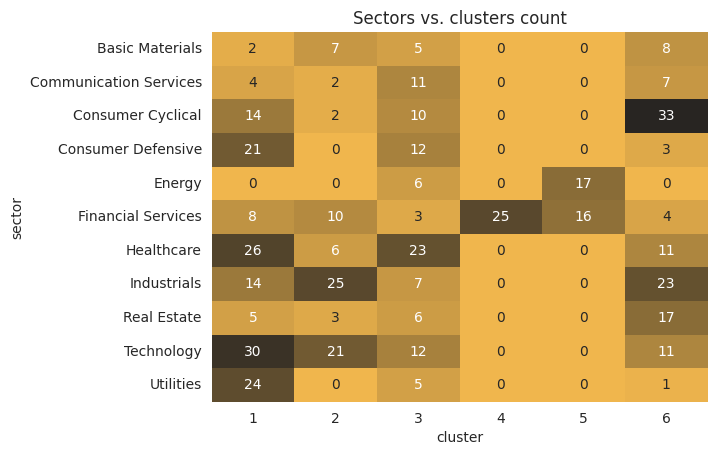

In [32]:
# Heatmap to see which sectors are in which cluster
sns.heatmap(pd.crosstab(sector_cluster.sector, sector_cluster.cluster), cmap = sns.dark_palette(LIGHT_COL, reverse=True, as_cmap=True),
            annot = pd.crosstab(sector_cluster.sector, sector_cluster.cluster), cbar = False)
plt.title("Sectors vs. clusters count")
plt.show()

In [33]:
# Count of clusters
df_clustering_result[["cluster", "beta_const"]].groupby("cluster").count()

,beta_const
cluster,
1,148
2,76
3,100
4,25
5,33
6,118


In [34]:
# Mean of coefficients
df_clustering_result.groupby("cluster").mean()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
cluster,,,,,,,,,,,,,
1,0.003366,0.899769,-0.018268,-0.111660,0.176067,0.196554,0.150239,42.213290,-1.648550,-2.704798,3.857051,3.479473,0.390952
2,-0.001355,1.105417,0.075972,0.066575,0.188573,0.009723,-0.039847,59.305480,1.856211,2.006163,4.189369,0.312574,0.569652
3,0.016348,0.937118,0.190564,-0.038504,-0.098533,-0.000015,0.285375,26.766987,2.295648,-0.817736,-0.363492,0.559760,0.286506
4,-0.012039,1.165443,0.033732,1.363090,-0.376666,-0.729889,-0.633179,65.166349,0.479180,41.745331,-8.078517,-11.354502,0.722197
5,-0.015269,1.133850,0.114555,0.989882,-0.295595,-0.057181,-0.483713,47.211478,1.769495,22.302384,-3.971051,-1.118264,0.533791
6,-0.014911,1.036012,0.367717,0.317191,0.284907,-0.065883,-0.495447,40.409361,7.169984,6.785655,4.490643,-0.456331,0.418566


## Comments

Let us see what typical characteristics of each clusters are. Here we compare the coefficients among each other, hence "low impact of X" means that the impact is low compared to other clusters.

**Cluster 1: Positive impact of market, very negative impact of HML, positive impact of RMW & CMA**. This is similar to how the utilies sector behaves, as discussed in the previous section. Consequently, we see that the vast majority of utilies companies fall into this sector. This cluster is also made of Healthcare and Technology companies.

**Cluster 2: Positive impact of market, positive impact of HML, positive impact of RMW.** These are made up of mostly Technology and Industrials companies. 

**Cluster 3: Positive impact of market, positive impact of SMB. Low R2.** Contains a lot of different industries, no clear dominance. Seems to be a cluster where we have "rest-companies" that cannot be attributed to any cluster, the low R2 score shows that too. That means that these are companies which are not well explained by FF-factors.

**Cluster 4: Positive impact of market, positive impact of HML, negative impact of RMW & CMA. High R2.**. Made up of only companies of the financial services. The high R2 implies that FF-factors are well-suited to explain companies in this sector.

**Cluster 5: Positive impact of market, positive impact of HML, negative impact of RMW**. Made up of only Energy and Financial services. Most notably, almost all energy companies are in this sector.

**Cluster 6: Positive impact of market, SMB, HML, RMW**. No clear dominant industry in this sector.

## Other approach: Clustering based on spectral features extracted from returns time series

- No clear differences among the different time series -> difficult to cluster
- Features difficult to interpret!

In [ ]:
returns.fillna(0)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092166,10.724563,-0.596149,0.172770,0.000000,-0.716046,-0.811195,-0.334110,0.616135,...,5.904167,-1.193060,0.389701,-1.195930,0.000000,-0.342586,3.116528,-0.174548,3.465158,0.000000
2,2010-01-06,-0.355955,-4.231411,0.868152,-1.603434,0.000000,-0.950013,0.553758,-0.433244,1.057452,...,-1.320423,0.191861,0.860535,0.656664,0.000000,-0.717446,-0.032290,-0.771667,8.338131,0.000000
3,2010-01-07,-0.129771,2.904340,-0.024734,-0.185038,0.000000,-1.616682,0.825047,-0.589966,-0.093530,...,2.113132,-0.432173,-0.314650,1.300615,0.000000,-0.028801,2.268099,-2.531778,10.616022,0.000000
4,2010-01-08,-0.032452,-1.926821,0.394523,0.662638,0.000000,1.080681,0.509911,-0.197437,-0.398564,...,-0.719045,0.048133,-0.401974,0.000000,0.000000,0.028801,-2.122795,-0.325557,-1.631939,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


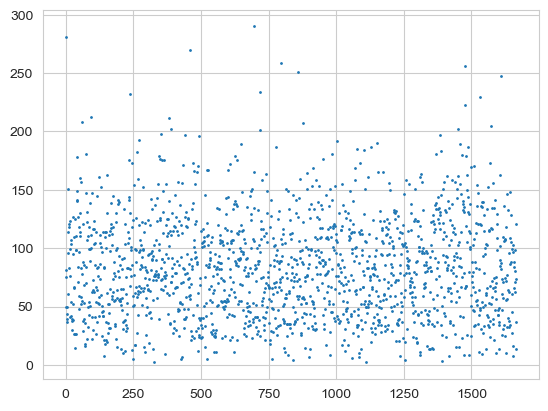

In [ ]:
from scipy.fft import fft

stocks = returns.columns[1:] # Excludes Date
X = returns[stocks].fillna(0)
ys = []
for i, stock in enumerate(stocks):
    vals = X[stock].to_numpy()
    y = fft(vals)
    ys.append(y)
ys = np.array(ys)
intensity_freqs = abs(ys)[:, :ys.shape[1]//2]
y = intensity_freqs[111]
plt.scatter(range(len(y)), y, s = 1)
plt.show()

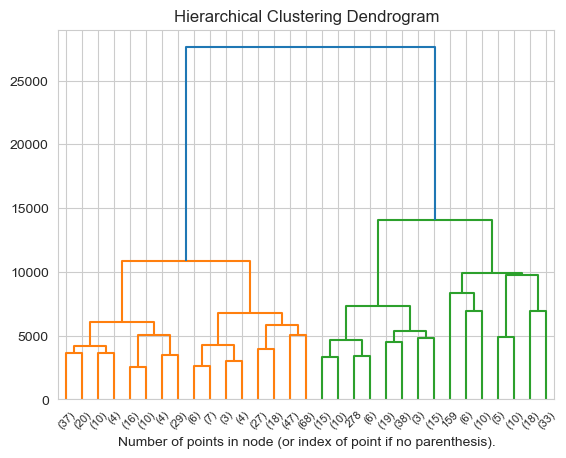

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(intensity_freqs)
plt.title(f"Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Other approach: Clustering based on raw returns time series

Difficult to extract common characteristics out of the raw time series, difficult to interpret. 

In [ ]:
stocks = returns.columns[1:] # Excludes Date
X = df[stocks]

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
1,-1.092166,10.724563,-0.596149,0.172770,0.172770,-0.716046,-0.811195,-0.334110,0.616135,1.631272,...,-1.193060,0.389701,-1.195930,-1.195930,-0.342586,3.116528,-0.174548,3.465158,3.465158,8
2,-0.355955,-4.231411,0.868152,-1.603434,-1.603434,-0.950013,0.553758,-0.433244,1.057452,-0.212432,...,0.191861,0.860535,0.656664,0.656664,-0.717446,-0.032290,-0.771667,8.338131,8.338131,8
3,-0.129771,2.904340,-0.024734,-0.185038,-0.185038,-1.616682,0.825047,-0.589966,-0.093530,-1.959530,...,-0.432173,-0.314650,1.300615,1.300615,-0.028801,2.268099,-2.531778,10.616022,10.616022,8
4,-0.032452,-1.926821,0.394523,0.662638,0.662638,1.080681,0.509911,-0.197437,-0.398564,-0.543629,...,0.048133,-0.401974,0.000000,0.000000,0.028801,-2.122795,-0.325557,-1.631939,-1.631939,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,-0.483886,...,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596,8
3330,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,0.066975,...,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149,8
3331,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,1.530807,...,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560,5
3332,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,0.720049,...,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838,10


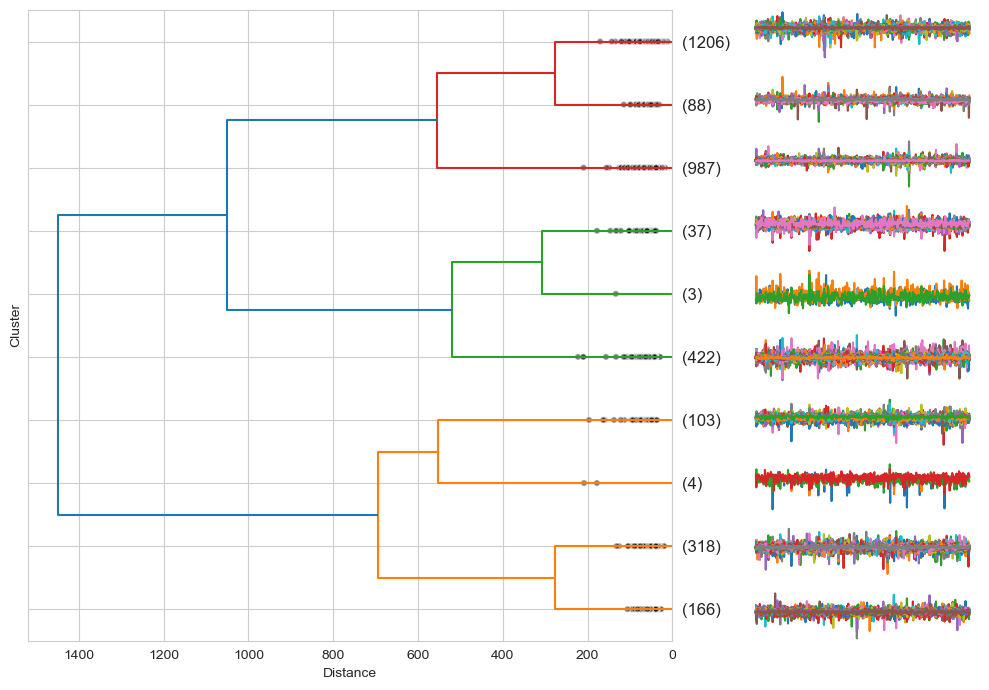

In [ ]:
from dendrogram_ts import maxclust_draw

sns.set_style('whitegrid')
plt.figure(figsize=(10,7));

maxclust_draw(X.fillna(method="ffill", axis = 1), 'ward', metric= "euclidean", max_cluster=10, ts_hspace=3)

# 6. Sort the estimated constants and provide the names of the five companies with the highest constant and the five with lowest constant. Comment.

In [36]:

def print_top_bottom_5(df_ols_results):
    """
    Function that shows the top and bottom 5 companies according to their alpha
    """
    df_constants = df_ols_results[["stock", "beta_const"]]
    df_constants = df_constants.sort_values(by ="beta_const", ascending=False)
    top_5 = df_constants.iloc[:5]
    bottom_5 = df_constants.iloc[-5:]

    print("############## Top 5 Companies ###############")
    i = 1
    for _, row in top_5.iterrows():
        stock, const = row
        ticker = yf.Ticker(stock)
        name = ticker.get_info()["longName"]
        sector = ticker.get_info()["sector"]
        print(f"{i}. {name} (sector: {sector}, alpha: {const: .3f})")
        i += 1
    
    print("############ Bottom 5 Companies ##############")
    i = 0
    for _, row in bottom_5.iterrows():
        stock, const = row
        ticker = yf.Ticker(stock)
        name = ticker.get_info()["longName"]
        sector = ticker.get_info()["sector"]
        print(f"{496+i}. {name} (sector: {sector}, alpha: {const: .3f})")
        i += 1

In [37]:
print_top_bottom_5(df_ols_results)

############## Top 5 Companies ###############
1. GE HealthCare Technologies Inc. (sector: Healthcare, alpha:  0.325)
2. Constellation Energy Corporation (sector: Utilities, alpha:  0.221)
3. Moderna, Inc. (sector: Healthcare, alpha:  0.177)
4. Tesla, Inc. (sector: Consumer Cyclical, alpha:  0.093)
5. Carrier Global Corporation (sector: Industrials, alpha:  0.093)
############ Bottom 5 Companies ##############
496. WestRock Company (sector: Consumer Cyclical, alpha: -0.078)
497. APA Corporation (sector: Energy, alpha: -0.080)
498. Carnival Corporation & plc (sector: Consumer Cyclical, alpha: -0.081)
499. DISH Network Corporation (sector: Communication Services, alpha: -0.082)
500. Norwegian Cruise Line Holdings Ltd. (sector: Consumer Cyclical, alpha: -0.087)


**Comment:** Here we can see which companies perform systematically better than others and those that are worse than others. 

Among the top performers we have two healthcare companies, that performed well probably because of Covid. Constellation Energy performed well because it joined the S&P 500 in 2022, which was a period very affected by the war in Ukraine, which positively impacted the energy sector.

In the bottom 5 companies we have three Consumer Cyclical companies, which may have been hit hard by the Covid crisis. 

# 7. Temporally aggregating your returns to monthly frequency and taking monthly Fama-French data, redo the analysis and compare your findings with the daily frequency results.

## 7.0 Get monthly data

In [15]:
# Download monthly data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data_monthly = yf.download(tickers, start = start, end = end, interval="1mo")
prices_monthly = data_monthly["Adj Close"].reset_index()
# Drop columns without any data
prices_monthly = prices_monthly.drop(["BF.B", "BRK.B", "HON"], axis=1)

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


In [ ]:
prices_monthly

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,^GSPC
0,2010-01-01,18.300039,5.005957,37.547535,5.898321,NaN,22.624672,19.226805,7.948889,32.124466,...,13.734278,40.237892,31.112370,NaN,19.401821,49.998180,26.100000,16.480963,NaN,1073.869995
1,2010-02-01,20.539387,6.910295,38.832451,6.284050,NaN,23.272045,19.857437,8.220000,31.325090,...,13.754104,40.593868,30.704088,NaN,19.236164,50.894810,28.570000,16.107380,NaN,1104.489990
2,2010-03-01,22.452307,6.929150,39.898415,7.217045,NaN,24.073309,19.272106,8.472222,32.876835,...,14.011874,42.103313,32.365032,NaN,21.866020,52.554913,29.600000,18.984936,NaN,1169.430054
3,2010-04-01,23.673182,6.665183,42.983742,8.018289,NaN,25.679865,18.716043,8.397778,34.201305,...,14.541085,42.599895,34.056648,NaN,24.199232,54.072968,29.049999,24.974226,NaN,1186.689941
4,2010-05-01,21.126976,8.324407,49.331234,7.888996,NaN,26.037804,17.545616,8.168889,29.663067,...,13.698705,38.004868,30.135260,NaN,23.480440,49.651962,27.500000,20.819105,NaN,1089.410034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,154.979996,14.430000,150.990005,148.029999,161.179993,170.690002,107.580002,59.910000,300.929993,...,70.220001,111.339996,30.260000,112.349998,128.660004,120.099998,270.279999,51.820000,154.139999,4080.110107
155,2022-12-01,149.649994,12.720000,147.029999,129.929993,161.610001,165.710007,109.790001,62.779999,266.839996,...,70.110001,110.300003,31.840000,110.570000,128.080002,127.500000,256.410004,49.160000,146.550003,3839.500000
156,2023-01-01,152.080002,16.139999,152.279999,144.289993,147.750000,168.960007,110.550003,64.349998,279.049988,...,68.769997,116.010002,36.830002,104.010002,130.509995,127.339996,316.179993,53.160000,165.490005,4076.600098
157,2023-02-01,141.970001,15.980000,144.960007,147.410004,153.899994,155.559998,101.720001,70.000000,265.549988,...,64.570000,109.910004,38.070000,102.650002,127.160004,123.870003,300.250000,50.619999,167.000000,3970.149902


In [16]:
# Compute returns
returns_monthly = prices_monthly.copy()
Diffs_monthly = np.diff(returns_monthly.iloc[:,1:],axis=0)
Returns_monthly = Diffs_monthly*100/prices_monthly.iloc[:-1,1:]
# We assume the first return to be 0
Returns_monthly = np.vstack((np.zeros(Returns_monthly.shape[1]),Returns_monthly))
returns_monthly.iloc[:,1:] = Returns_monthly
# Isolate S&P 500
sp500_monthly = returns_monthly[["Date","^GSPC"]]
returns_monthly = returns_monthly.drop("^GSPC", axis = 1)
returns_monthly

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-02-01,12.236894,38.041438,3.422019,6.539646,NaN,2.861314,3.279965,3.410684,-2.488421,...,2.731066,0.144406,0.884682,-1.312270,NaN,-0.853808,1.793323,9.463599,-2.266802,NaN
2,2010-03-01,9.313423,0.272848,2.745108,14.846976,NaN,3.443063,-2.947703,3.068395,4.953753,...,19.285860,1.874083,3.718403,5.409535,NaN,13.671395,3.261833,3.605183,17.864922,NaN
3,2010-04-01,5.437654,-3.809516,7.732934,11.102145,NaN,6.673567,-2.885330,-0.878692,4.028554,...,16.365500,3.776930,1.179422,5.226719,NaN,10.670520,2.888483,-1.858112,31.547624,NaN
4,2010-05-01,-10.755666,24.893925,14.767185,-1.612432,NaN,1.393847,-6.253593,-2.725584,-13.269198,...,-4.941055,-5.793101,-10.786464,-11.514352,NaN,-2.970279,-8.175978,-5.335626,-16.637671,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,12.214101,1.763047,-20.498106,-3.462883,11.215906,8.567613,9.245602,4.191304,6.469954,...,30.923325,7.848271,0.478304,-1.817000,9.684668,8.803394,5.955005,-4.568887,-0.231043,2.445629
155,2022-12-01,-3.439149,-11.850312,-2.622697,-12.081654,0.266786,-2.619005,2.054288,4.790517,-11.328218,...,-1.422432,-0.156655,-0.136567,5.221411,-1.321493,0.005440,6.161533,-5.131713,-4.359885,-4.924098
156,2023-01-01,1.775353,26.886785,4.665070,11.052102,-8.576205,1.961258,0.692233,2.500796,4.575779,...,25.669942,-1.237878,5.176792,16.140740,-5.932889,1.897242,0.063917,23.310319,8.136702,12.923925
157,2023-02-01,-6.647823,-0.991325,-4.806933,2.162327,5.152609,-7.930880,-7.570733,8.780111,-4.448597,...,4.563882,-6.107307,-5.258173,3.366809,-1.307569,-2.566846,-2.724985,-5.038267,-4.778036,1.149548


In [17]:
# Read monthly FF data
ff_monthly = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3.csv") if not collab else pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
ff_monthly = ff_monthly.rename({"Unnamed: 0": "Date"}, axis = 1)
ff_monthly["Date"] = pd.to_datetime(ff_monthly["Date"], format="%Y%m")
# Merge dataframes based on date
df_monthly = pd.merge(ff_monthly, returns_monthly, on = "Date", how = "inner", suffixes=["_FF", ""])
df_monthly

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-01,-3.36,0.34,0.43,-1.27,0.46,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-02-01,3.40,1.51,3.23,-0.27,1.43,0.00,12.236894,38.041438,3.422019,...,2.731066,0.144406,0.884682,-1.312270,NaN,-0.853808,1.793323,9.463599,-2.266802,NaN
2,2010-03-01,6.31,1.85,2.21,-0.65,1.69,0.01,9.313423,0.272848,2.745108,...,19.285860,1.874083,3.718403,5.409535,NaN,13.671395,3.261833,3.605183,17.864922,NaN
3,2010-04-01,2.00,4.98,2.89,0.69,1.72,0.01,5.437654,-3.809516,7.732934,...,16.365500,3.776930,1.179422,5.226719,NaN,10.670520,2.888483,-1.858112,31.547624,NaN
4,2010-05-01,-7.89,0.04,-2.44,1.30,-0.22,0.01,-10.755666,24.893925,14.767185,...,-4.941055,-5.793101,-10.786464,-11.514352,NaN,-2.970279,-8.175978,-5.335626,-16.637671,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,4.60,-2.67,1.38,6.01,3.11,0.29,12.214101,1.763047,-20.498106,...,30.923325,7.848271,0.478304,-1.817000,9.684668,8.803394,5.955005,-4.568887,-0.231043,2.445629
155,2022-12-01,-6.41,-0.16,1.32,0.09,4.19,0.33,-3.439149,-11.850312,-2.622697,...,-1.422432,-0.156655,-0.136567,5.221411,-1.321493,0.005440,6.161533,-5.131713,-4.359885,-4.924098
156,2023-01-01,6.65,4.43,-4.05,-2.62,-4.53,0.35,1.775353,26.886785,4.665070,...,25.669942,-1.237878,5.176792,16.140740,-5.932889,1.897242,0.063917,23.310319,8.136702,12.923925
157,2023-02-01,-2.58,0.69,-0.78,0.90,-1.41,0.34,-6.647823,-0.991325,-4.806933,...,4.563882,-6.107307,-5.258173,3.366809,-1.307569,-2.566846,-2.724985,-5.038267,-4.778036,1.149548


## 7.1 Estimate regression coefficients

In [18]:
# Estimate monthly coefficients
X_monthly = prepare_data_ols(df_monthly)
df_ols_results_monthly = ols_estimation(df_monthly, X_monthly, returns_monthly)
df_ols_results_monthly

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,0.298156,1.215056,-0.020282,-0.148068,-0.259675,0.046553,0.699636,12.149523,-0.104949,-0.851349,-1.110057,0.173542,0.536956
1,AAL,0.374067,1.022033,1.218077,0.337465,0.492118,0.333777,0.359558,4.186174,2.581863,0.794811,0.861736,0.509688,0.225940
2,AAP,0.026699,0.799219,0.761040,0.187706,1.085300,-0.074724,0.042646,5.439885,2.680638,0.734658,3.158103,-0.189617,0.300643
3,AAPL,0.965112,1.150798,-0.162534,-0.470423,0.768503,-0.255453,1.989064,10.106567,-0.738680,-2.375612,2.885377,-0.836394,0.477777
4,ABBV,0.911928,0.798576,0.149678,-0.131349,0.171418,0.619112,1.412850,5.054761,0.514941,-0.520325,0.470174,1.580936,0.222900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,0.294129,0.815836,0.211598,0.023784,1.001733,-0.117098,0.706672,8.352520,1.121070,0.140018,4.384490,-0.446953,0.418070
496,ZBH,-0.171519,1.000804,-0.087158,0.016346,-0.462905,0.409760,-0.394176,9.800766,-0.441695,0.092048,-1.938007,1.496019,0.429047
497,ZBRA,0.798684,1.283209,0.741254,0.104372,0.274844,-1.147650,1.342329,9.189985,2.747204,0.429817,0.841505,-3.064241,0.513863
498,ZION,0.320482,1.053586,0.833509,1.591948,-0.767506,-0.977678,0.731211,10.243389,4.193633,8.899890,-3.190127,-3.543768,0.722342


## 7.2 Summary statistics

Comment: We observe that when using monthly data, the stock returns are less determines by the market though the market still has a positive effect on them. Then we observe that all coefficients except for the constant and their t-statistics are decreasing in the case of monthly data, along with the R2. We also observe that the standard deviations are decreasing too, which implies that the spread of the coefficients values is reducing too.

Interestingly we see that the constant is the only parameter is increasing on average (along with the standard deviation). This is probably due to the fact that monthly returns are higher on average than daily returns.

In [70]:
# Summary statistics of monthly coefficients
df_ols_results_monthly.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.423134,0.985370,0.118359,0.137326,0.067810,-0.003316,0.728642,8.286591,0.316177,0.717701,0.370842,0.066935,0.411291
std,0.744542,0.347221,0.409261,0.549518,0.487390,0.582893,1.007494,3.002551,1.624910,2.730466,1.696750,1.783169,0.159837
min,-1.271146,-0.919799,-1.524657,-2.426226,-2.370404,-2.066411,-2.281258,-0.000000,-4.898710,-5.301800,-5.510778,-5.947155,0.018072
25%,0.000466,0.771374,-0.167239,-0.204872,-0.228664,-0.356127,0.000587,6.111312,-0.760622,-1.058491,-0.743338,-1.118023,0.290102
50%,0.343631,0.973489,0.109029,0.066842,0.112300,0.031739,0.745728,8.115209,0.424823,0.303970,0.387364,0.110510,0.413505
75%,0.705778,1.195919,0.362255,0.419117,0.396739,0.375841,1.456677,10.228315,1.463024,1.702961,1.551203,1.161257,0.526632
max,5.991423,2.412963,2.196683,1.926319,2.042015,2.421194,3.219668,17.219948,5.048507,11.103839,4.848969,5.197906,1.000000


In [69]:
# Difference to daily
summary_stats_diff = df_ols_results_monthly.describe() - df_ols_results.describe()
summary_stats_diff

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
mean,0.424202,-0.014014,-0.021923,-0.040385,-0.022158,-0.007154,0.813663,-34.487257,-1.769988,-3.783707,-1.728708,-0.373227,-0.018441
std,0.711429,0.131175,0.109459,0.051321,0.162540,0.155954,0.082753,-9.756677,-4.500355,-9.534770,-3.627547,-3.667423,0.025133
min,-1.184216,-1.359867,-0.976276,-1.506191,-1.233372,-0.510043,0.461998,-2.348171,10.602516,11.477681,14.384411,11.964492,-0.040572
25%,0.017339,-0.075959,-0.069364,-0.040123,-0.166154,-0.140608,0.698765,-28.610676,1.567375,3.066063,0.319291,1.377653,-0.041002
50%,0.345415,-0.028510,-0.000239,-0.031052,-0.036458,-0.026809,0.825666,-33.130025,-2.099202,-2.016334,-1.891528,-0.575305,-0.012882
75%,0.693135,0.049458,0.025591,0.030189,0.071942,0.085022,0.923998,-40.374480,-5.189085,-6.910406,-4.617511,-2.488301,0.004245
max,5.666456,0.737337,0.839079,0.119044,1.153708,1.449410,0.761415,-66.147629,-12.274625,-41.335479,-9.750574,-9.125389,0.216703


## 7.3 Plot KDEs of statistics

Comment: We observe what we discussed in the descriptive statistics: the average of almost all coefficients decreases slightly along with the variance. The R2 has an increased spread, with extreme values being more prominent (one observation has R2 = 1, as it has only three data points with 5 regressors).

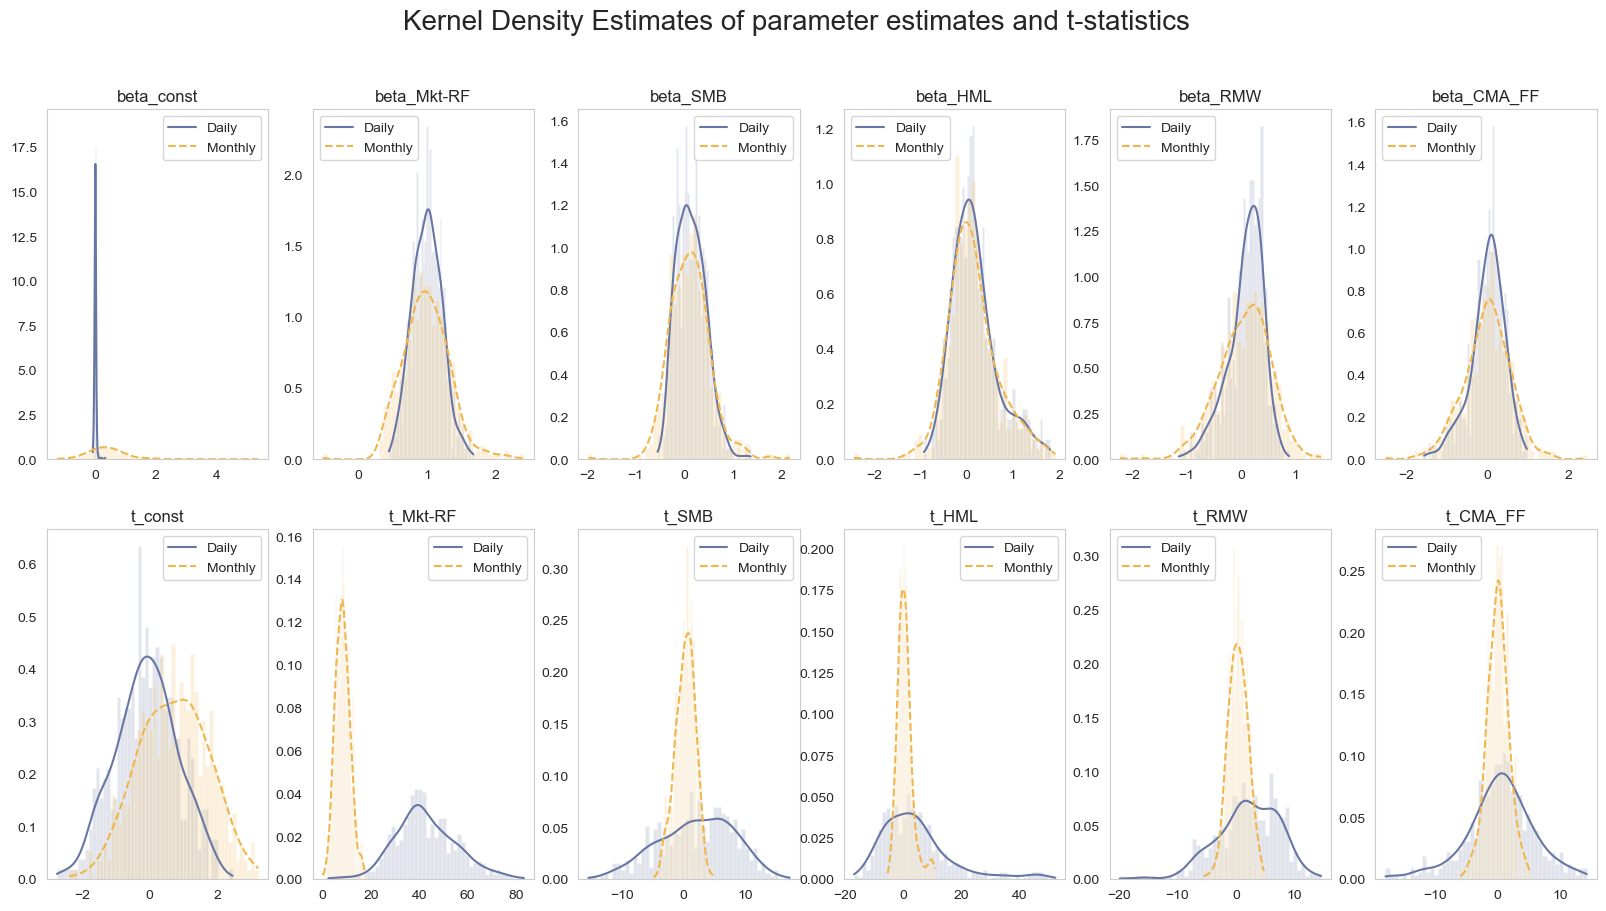

In [ ]:
kde_statistics(df_ols_results, df_ols_results_monthly)

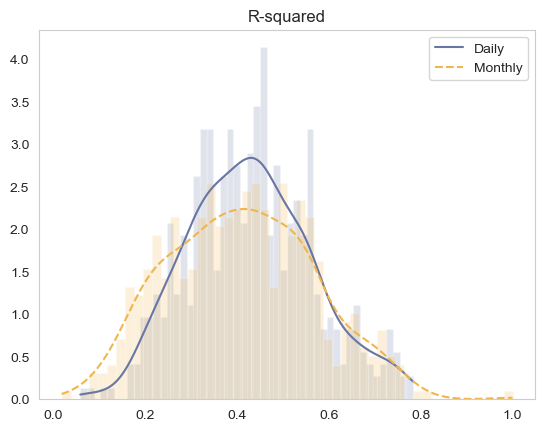

In [ ]:
plot_r_squared(df_ols_results, df_ols_results_monthly)

**Outlier due to GEHC 3 data points with 5 regressors.**

## 7.4 Differences between sectors

Comment: For this part the most notable difference is in the constant. We observe that the mean increases slightly but the variance increases a lot by a lot. This goes back to what we noticed before.

In [42]:
df_results_sectors_monthly = add_sector(df_ols_results_monthly)

 16%|█▌        | 80/500 [00:14<01:12,  5.83it/s]

No sector found for CAT


100%|██████████| 500/500 [01:30<00:00,  5.54it/s]


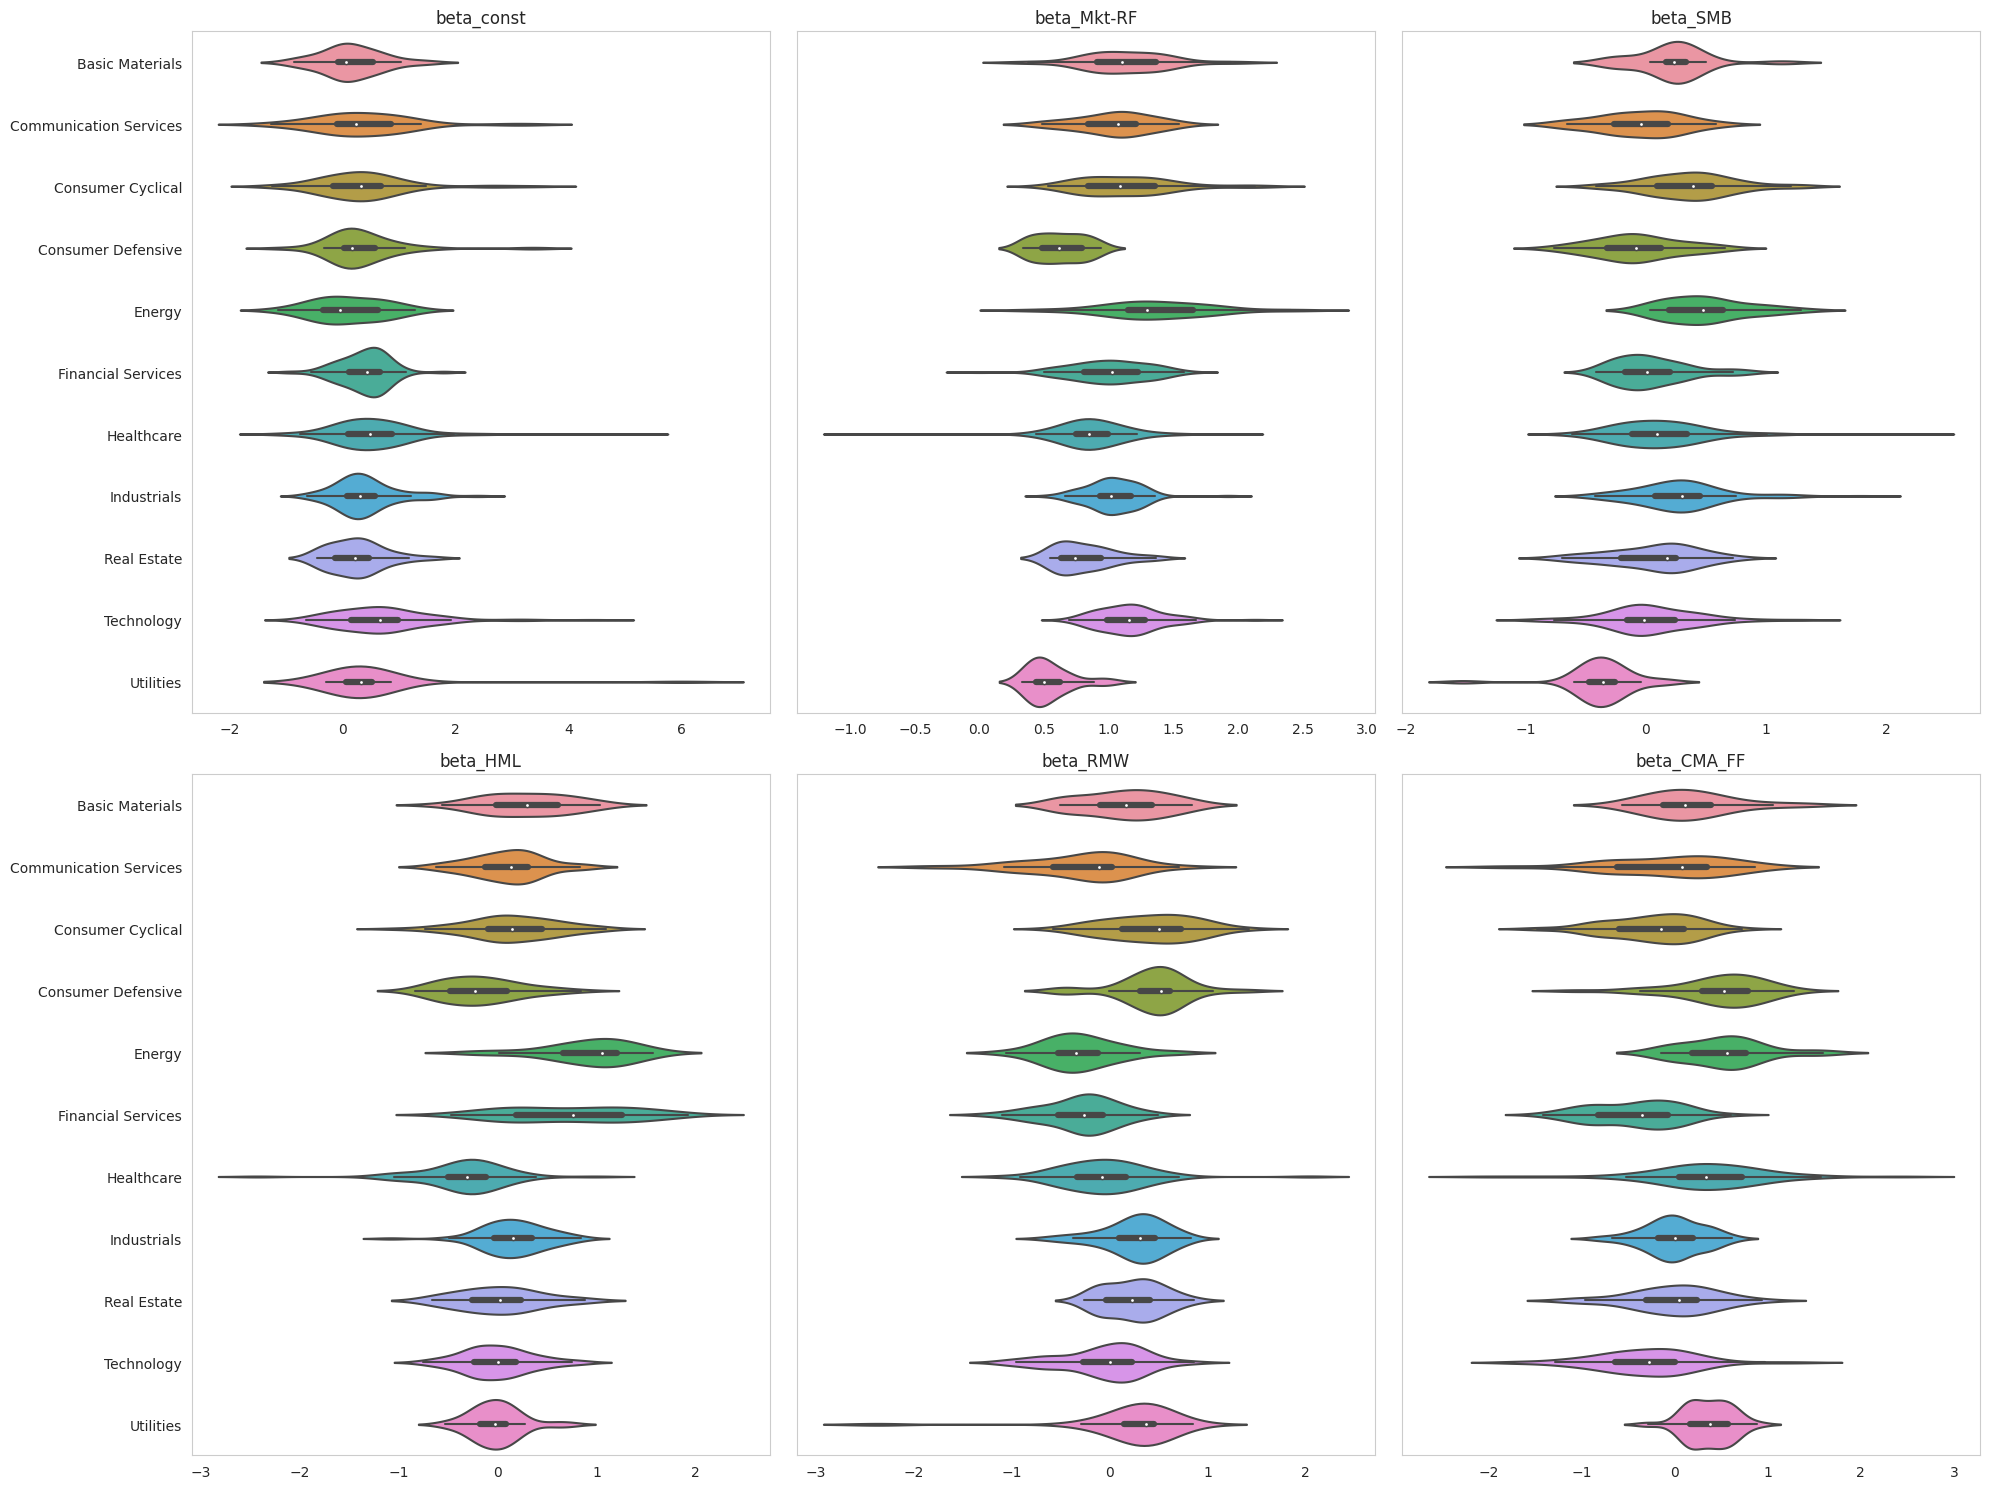

In [43]:
plot_violin_sector(df_results_sectors_monthly)

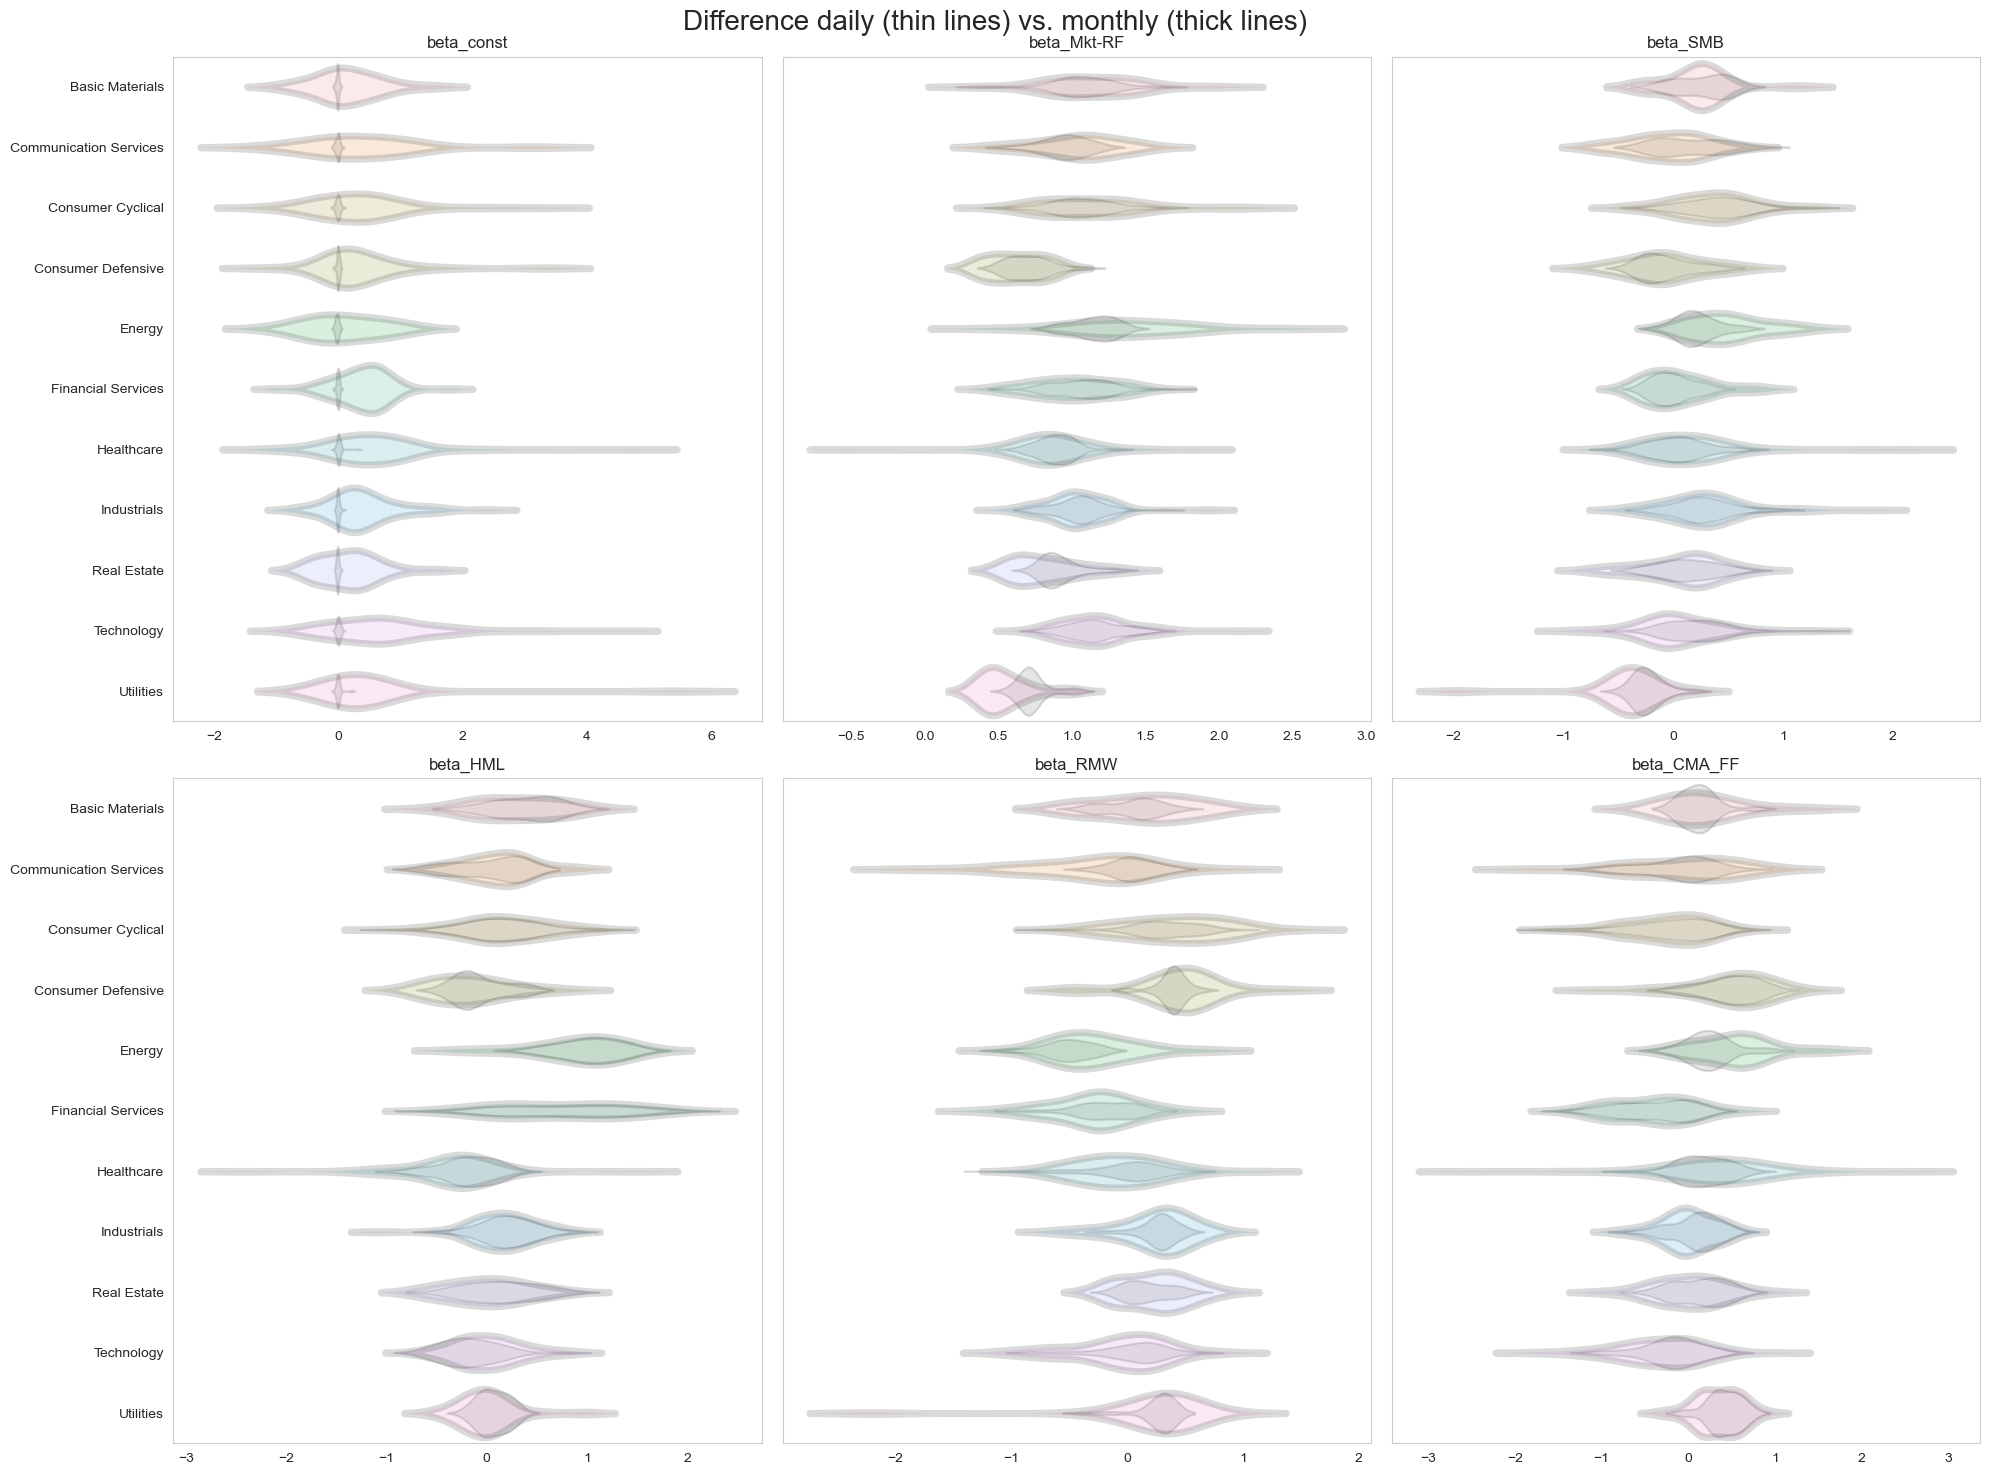

In [ ]:
plot_violin_sector(df_results_sector, df_results_sectors_monthly)

## 7.5 Monthly clustering
Here we will proceed in the same way as in the daily case: we compute 6 clusters. The idea behind it is that we want to see if the same clusters are being formed in the monthly case (even though 6 might not be the optimal number of clusters). 

Results: the clusters are not the same, with some exceptions. In both cases we have a cluster that only contains the financial services sector. Furthemore it seems like cluster 1 (daily) is similar to cluster 2 (monthly). Other than that, we observe a large difference in the clustering when going from daily returns to monthly returns and can't say that we observe a lot of similarity.

In [19]:
monthly_df_clustering_ff = prep_cluster_ff_coefs(df_ols_results_monthly.dropna())
monthly_df_clustering_ff

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF
A,0.298156,1.215056,-0.020282,-0.148068,-0.259675,0.046553,0.699636,12.149523,-0.104949,-0.851349,-1.110057,0.173542
AAL,0.374067,1.022033,1.218077,0.337465,0.492118,0.333777,0.359558,4.186174,2.581863,0.794811,0.861736,0.509688
AAP,0.026699,0.799219,0.761040,0.187706,1.085300,-0.074724,0.042646,5.439885,2.680638,0.734658,3.158103,-0.189617
AAPL,0.965112,1.150798,-0.162534,-0.470423,0.768503,-0.255453,1.989064,10.106567,-0.738680,-2.375612,2.885377,-0.836394
ABBV,0.911928,0.798576,0.149678,-0.131349,0.171418,0.619112,1.412850,5.054761,0.514941,-0.520325,0.470174,1.580936
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.294129,0.815836,0.211598,0.023784,1.001733,-0.117098,0.706672,8.352520,1.121070,0.140018,4.384490,-0.446953
ZBH,-0.171519,1.000804,-0.087158,0.016346,-0.462905,0.409760,-0.394176,9.800766,-0.441695,0.092048,-1.938007,1.496019
ZBRA,0.798684,1.283209,0.741254,0.104372,0.274844,-1.147650,1.342329,9.189985,2.747204,0.429817,0.841505,-3.064241
ZION,0.320482,1.053586,0.833509,1.591948,-0.767506,-0.977678,0.731211,10.243389,4.193633,8.899890,-3.190127,-3.543768


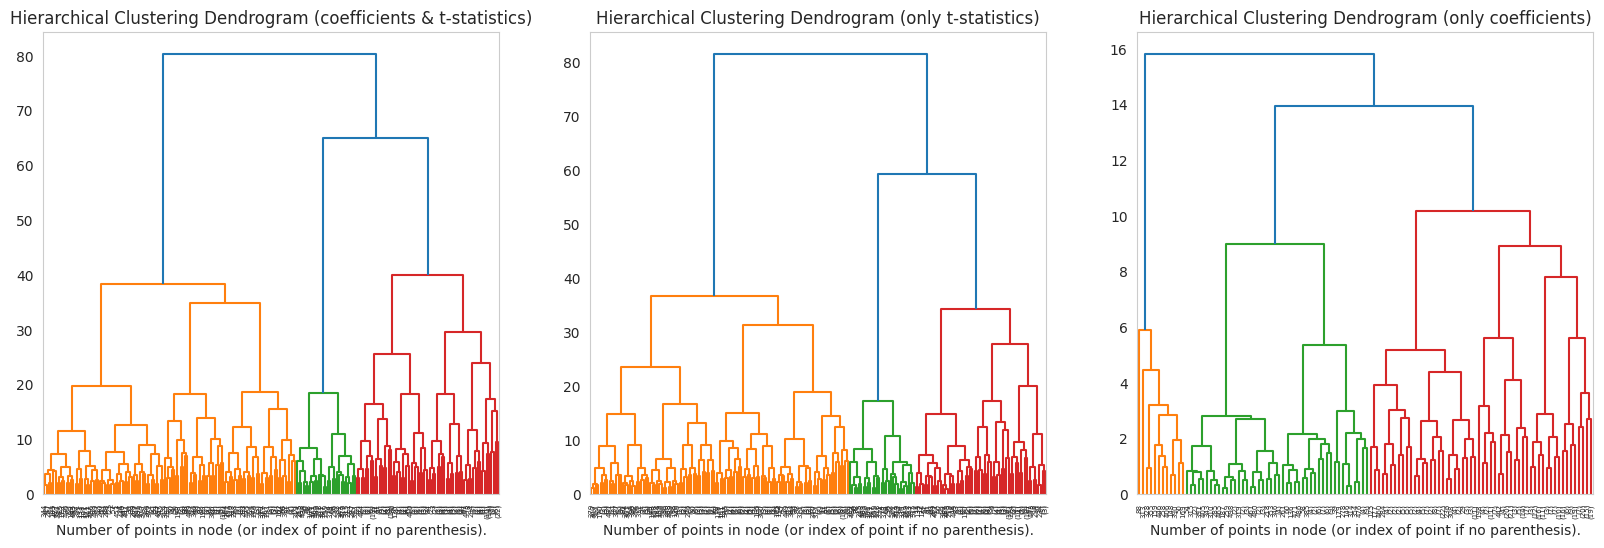

In [49]:
plot_dendrogram_ff(df_ols_results_monthly.fillna(0), p = 7)

In [22]:
# Fit model
df_ff_clustering_monthly = df_ols_results_monthly.iloc[:,1:].copy()
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(df_ff_clustering_monthly.fillna(0))

# Get model lables
df_clustering_result_monthly = df_ols_results.copy()
df_clustering_result_monthly["cluster"] = model.labels_  + 1
df_clustering_result_monthly = df_clustering_result_monthly.set_index("stock")

### Typical features of each cluster


In [28]:
sector_cluster_monthly = pd.merge(df_results_sector[["stock", "sector"]].set_index("stock"), df_clustering_result_monthly, on = "stock")[["sector", "cluster"]]

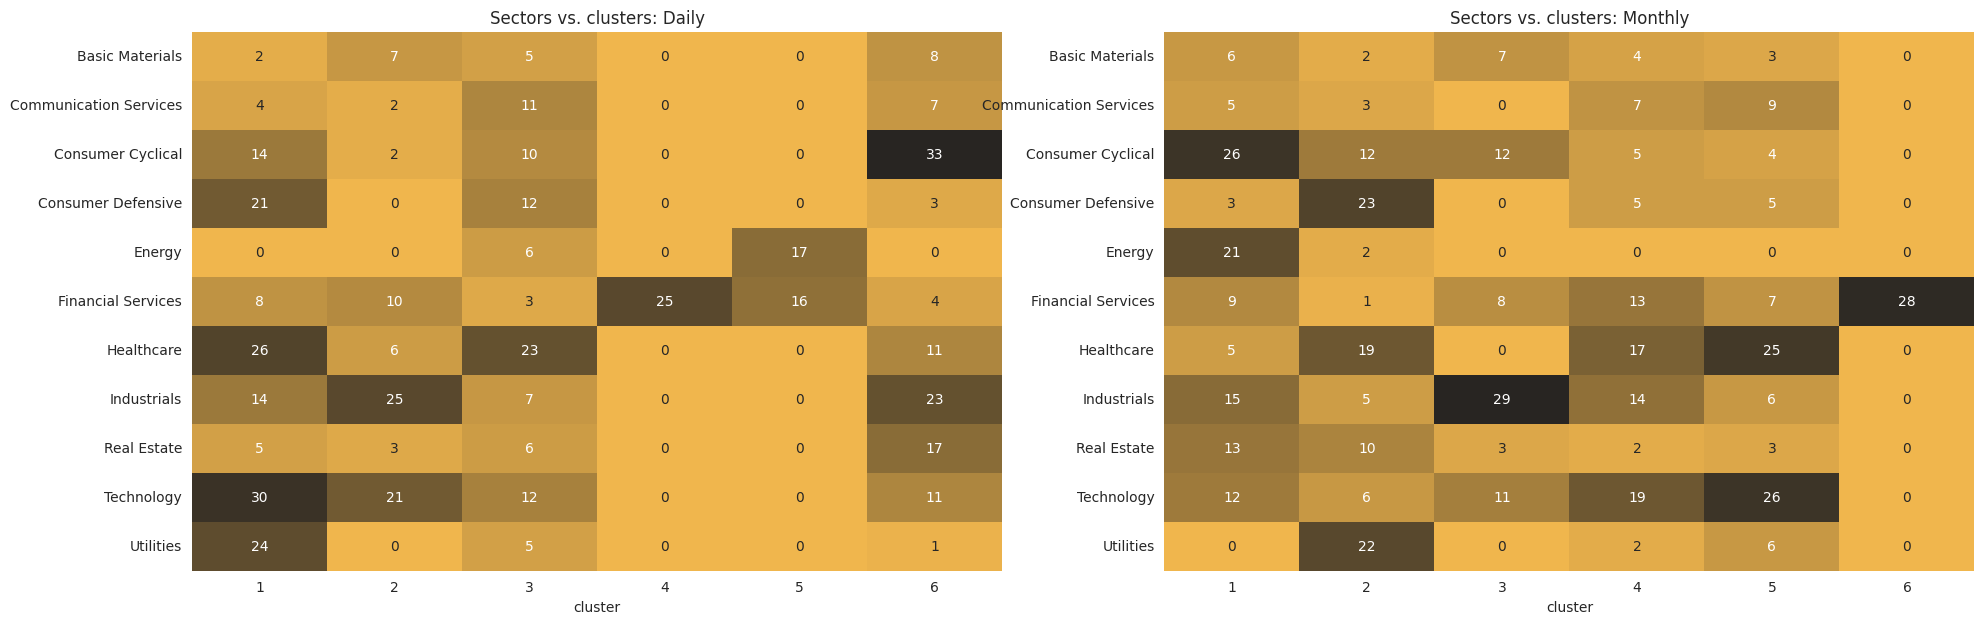

In [45]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (23, 7))

sns.heatmap(pd.crosstab(sector_cluster.sector, sector_cluster.cluster), cmap = sns.dark_palette(LIGHT_COL, reverse=True, as_cmap=True),
            annot = pd.crosstab(sector_cluster.sector, sector_cluster.cluster), cbar = False, ax = axs[0])
sns.heatmap(pd.crosstab(sector_cluster_monthly.sector, sector_cluster_monthly.cluster), cmap = sns.dark_palette(LIGHT_COL, reverse=True, as_cmap=True),
            annot = pd.crosstab(sector_cluster_monthly.sector, sector_cluster_monthly.cluster), cbar = False, ax = axs[1])
axs[0].set_title("Sectors vs. clusters: Daily")
axs[1].set_title("Sectors vs. clusters: Monthly")
axs[0].set_ylabel("")
axs[1].set_ylabel("")
plt.show()

In [24]:
# Mean of coefficients
df_clustering_result_monthly.groupby("cluster").mean()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
cluster,,,,,,,,,,,,,
1,-0.016463,1.088822,0.347611,0.490104,0.090103,-0.128549,-0.506956,39.607097,5.982643,9.494547,1.756215,-1.055073,0.435352
2,0.002497,0.788378,-0.056967,-0.123730,0.236438,0.355472,0.099056,36.803286,-2.282426,-3.177398,4.866989,5.277012,0.325122
3,-0.008986,1.143397,0.289372,0.248509,0.258863,-0.047939,-0.366284,55.163473,6.504168,6.366523,5.109560,-0.290717,0.545142
4,0.000946,0.989284,0.005250,0.036296,0.118276,0.059382,0.079527,49.372525,-0.737295,0.908112,2.520367,1.144737,0.474938
5,0.020890,0.976326,0.152227,-0.133304,-0.089483,-0.019166,0.427100,31.508445,1.974521,-1.735750,-0.220964,0.281649,0.326945
6,-0.011542,1.172457,0.040160,1.336402,-0.368429,-0.738741,-0.578778,64.269642,0.672171,40.352277,-7.922750,-11.408981,0.713383


In [25]:
# Count of clusters
df_clustering_result_monthly[["cluster", "beta_const"]].groupby("cluster").count()

,beta_const
cluster,
1,115
2,105
3,70
4,88
5,94
6,28


## 7.6 Monthly constants

**Comment:** Overall we see that we companies that perform well daily usually also perform well on the monthly scale. Indeed, 3 out of 5 top daily companies are also in the monthly top 5. Moreover for the bottom 5 companies, 4 out of 5 companies remain in the bottom 5 in the monthly case.

If we observe the value of the constants, we observe what we discussed earlier: the constant values are much more spread around 0, with larger extreme values.

In [61]:
print_top_bottom_5(df_ols_results)

############## Top 5 Companies ###############
1. GE HealthCare Technologies Inc. (sector: Healthcare, alpha:  0.325)
2. Constellation Energy Corporation (sector: Utilities, alpha:  0.221)
3. Moderna, Inc. (sector: Healthcare, alpha:  0.177)
4. Tesla, Inc. (sector: Consumer Cyclical, alpha:  0.093)
5. Carrier Global Corporation (sector: Industrials, alpha:  0.093)
############ Bottom 5 Companies ##############
496. WestRock Company (sector: Consumer Cyclical, alpha: -0.078)
497. APA Corporation (sector: Energy, alpha: -0.080)
498. Carnival Corporation & plc (sector: Consumer Cyclical, alpha: -0.081)
499. DISH Network Corporation (sector: Communication Services, alpha: -0.082)
500. Norwegian Cruise Line Holdings Ltd. (sector: Consumer Cyclical, alpha: -0.087)


In [62]:
print_top_bottom_5(df_ols_results_monthly)

############## Top 5 Companies ###############
1. Constellation Energy Corporation (sector: Utilities, alpha:  5.991)
2. Moderna, Inc. (sector: Healthcare, alpha:  5.043)
3. Enphase Energy, Inc. (sector: Technology, alpha:  4.415)
4. Tesla, Inc. (sector: Consumer Cyclical, alpha:  3.395)
5. Keurig Dr Pepper Inc. (sector: Consumer Defensive, alpha:  3.363)
############ Bottom 5 Companies ##############
496. Viatris Inc. (sector: Healthcare, alpha: -1.116)
497. APA Corporation (sector: Energy, alpha: -1.148)
498. Norwegian Cruise Line Holdings Ltd. (sector: Consumer Cyclical, alpha: -1.149)
499. Carnival Corporation & plc (sector: Consumer Cyclical, alpha: -1.250)
500. DISH Network Corporation (sector: Communication Services, alpha: -1.271)


## Overall Comment

The main takeaway from this question is that the constant of the regression are higher on average with a much wider range of values. This means that the alpha observed vary more, which means that when evaluating the performance of a company, the time interval is very important. That being said, the last question shows that top performers in the daily case are also performing well in the monthly case.

# 8. As in the first question, estimate the daily data regressions but with left hand side variable $r^i_{t+1} − R^f_{t + 1}$ , that is one day ahead returns. How different are the results?

In [ ]:
X = prepare_data_ols(df)
X

,const,Mkt-RF,SMB,HML,RMW,CMA_FF
0,1.0,1.69,0.79,1.13,-0.17,0.21
1,1.0,0.31,-0.41,1.24,-0.19,0.19
2,1.0,0.13,-0.13,0.57,-0.05,0.20
3,1.0,0.40,0.25,0.98,-0.69,0.22
4,1.0,0.33,0.32,0.01,0.22,-0.37
...,...,...,...,...,...,...
3329,1.0,0.27,0.51,1.02,-0.28,0.35
3330,1.0,-0.17,-0.03,0.74,0.08,0.55
3331,1.0,1.39,-0.34,-0.50,-0.90,-0.54
3332,1.0,0.51,-0.61,-0.59,0.20,-0.09


In [ ]:
# Previous result: No forecast
df_ols_results.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001073,0.999385,0.140291,0.177697,0.089978,0.003850,-0.085198,42.773462,2.086370,4.501041,2.099705,0.440326,0.429731
std,0.033113,0.216041,0.299822,0.498204,0.324844,0.426940,0.924686,12.759200,6.125506,12.265380,5.324235,5.450606,0.134704
min,-0.086930,0.440068,-0.548381,-0.920035,-1.137032,-1.556368,-2.743255,2.348171,-15.501211,-16.779481,-19.895185,-17.911638,0.058644
25%,-0.016873,0.847333,-0.097875,-0.164749,-0.062508,-0.215519,-0.698177,34.721995,-2.327988,-4.124568,-1.062616,-2.495663,0.331105
50%,-0.001784,1.001999,0.109269,0.097894,0.148759,0.059204,-0.079938,41.245214,2.524024,2.320290,2.278885,0.685821,0.426387
75%,0.012642,1.146461,0.336663,0.388927,0.324796,0.290818,0.532678,50.602802,6.652103,8.613377,6.168719,3.649556,0.522387
max,0.324966,1.675626,1.357604,1.807276,0.888306,0.971784,2.458251,83.367639,17.323145,52.439310,14.599549,14.323287,0.783297


In [ ]:
# New result: forecast
df_ols_results_forecast = ols_estimation(df, X, returns, forecast=True)
df_ols_results_forecast.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.054155,-0.115475,0.126737,-0.075649,0.042767,-0.040036,1.629407,-3.711335,1.990512,-1.328474,0.515922,-0.247357,0.008658
std,0.033147,0.067125,0.089869,0.071702,0.087355,0.151226,0.839244,1.778812,1.131827,0.978632,0.900608,1.007840,0.006218
min,-0.077382,-0.372399,-0.409777,-0.975078,-0.424052,-0.652557,-0.722259,-8.881212,-1.781546,-4.324454,-3.091309,-3.178306,0.000703
25%,0.035351,-0.149967,0.069650,-0.111034,-0.004872,-0.101867,1.059158,-4.930979,1.261398,-1.982846,-0.066836,-0.884052,0.004598
50%,0.052496,-0.111922,0.121328,-0.074410,0.044498,-0.021900,1.685304,-3.692336,2.066282,-1.317234,0.557090,-0.223339,0.007463
75%,0.070651,-0.078777,0.173012,-0.037204,0.084384,0.042256,2.188638,-2.559388,2.754318,-0.657120,1.085891,0.433855,0.010934
max,0.367326,0.470720,0.507069,0.281095,0.596330,1.372113,3.643724,3.153701,5.412208,1.588884,4.353520,2.302881,0.082047


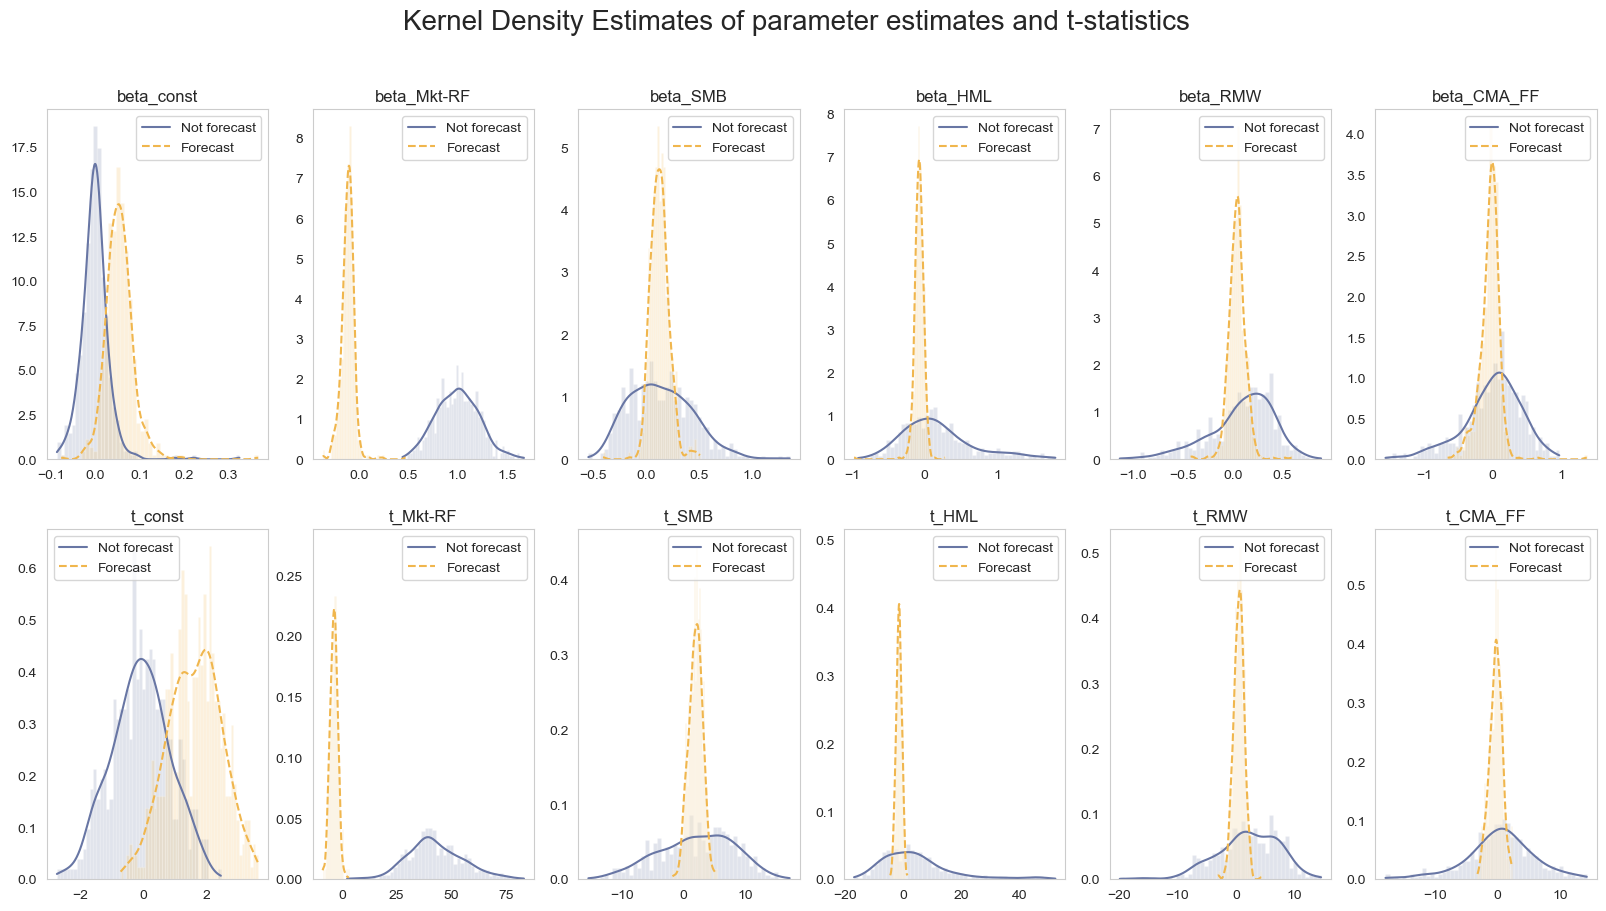

In [ ]:
kde_statistics(df_ols_results, df_ols_results_forecast, label1="Not forecast", label2 = "Forecast")

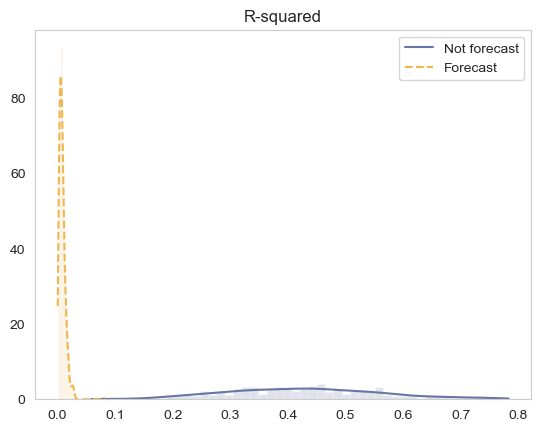

In [ ]:
plot_r_squared(df_ols_results, df_ols_results_forecast, label1="Not forecast", label2 = "Forecast" )

**Comment:** The most considerable difference between the two cases is in the R-squared, which captures the expressive power of the regressors. We observe that while before we had 40-50% of variation that was explained by the five FF factors, but once we try to forecast, this goes down to almost 0. This means that the FF factors are able to forecast returns, but predicting is a whole other story.

# 9. The model considered until now in (1) is a parametric linear regression model. Do you have other algorithms to link the factors to excess returns? If yes, show how they change the fit?

Here, we train a RandomForestRegressor and Linear Regression on the each stock and see the R2 for both for comparison - 16 mins runtime on CPU

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def ml_estimation_comparison(df, X, returns):
    stocks = returns.columns[1:]  # Excludes Date

    df_ml_results = pd.DataFrame(columns=["stock", "R2_RF", "R2_LR"])

    for stock in stocks:
        # Get dependent variable y: excess returns of stock
        y = df[stock] - df["RF_FF"]

        # Drop rows with missing values in y
        y = y.dropna()

        if y.empty:
            continue

        # Initialize and train the Random Forest regressor
        rf = RandomForestRegressor()
        rf.fit(X.loc[y.index], y)

        # Predict on the data using the Random Forest model
        y_pred_rf = rf.predict(X.loc[y.index])

        # Calculate R-squared for Random Forest
        r2_rf = r2_score(y, y_pred_rf)

        # Initialize and train the Linear Regression model
        lr = LinearRegression()
        lr.fit(X.loc[y.index], y)

        # Predict on the data using the Linear Regression model
        y_pred_lr = lr.predict(X.loc[y.index])

        # Calculate R-squared for Linear Regression
        r2_lr = r2_score(y, y_pred_lr)

        df_ml_results = pd.concat([df_ml_results, pd.DataFrame({"stock": [stock], "R2_RF": [r2_rf], "R2_LR": [r2_lr]})], ignore_index=True)

    return df_ml_results

comparison = ml_estimation_comparison(df, X, returns)
comparison.head()


,stock,R2_RF,R2_LR
0,A,0.932689,0.555602
1,AAL,0.893773,0.302043
2,AAP,0.888723,0.250085
3,AAPL,0.929158,0.539743
4,ABBV,0.889123,0.245479


The R-squared values indicate the goodness of fit for the Linear Regression (LR) and Random Forest (RF) models in predicting the excess returns for, example, the 'AAPL' stock.

For the 'AAPL' stock, the R-squared value of the Linear Regression model (R2_LR) is 0.539743, indicating that around 53.97% of the variance in the excess returns can be explained by the features in the dataset. This suggests a moderate level of fit for the Linear Regression model.

On the other hand, the R-squared value of the Random Forest model (R2_RF) is 0.929816, indicating that around 92.98% of the variance in the excess returns can be explained by the features in the dataset. This implies a higher level of fit for the Random Forest model compared to the Linear Regression model.

The substantial increase in the R-squared value from LR to RF suggests that the Random Forest model captures more complex relationships and non-linearities present in the data, resulting in a better fit and improved prediction performance for the 'AAPL' stock.

In summary, the Random Forest model shows a significant improvement in capturing the variability of the excess returns for the 'AAPL' stock compared to the Linear Regression model. It demonstrates the advantage of using an ensemble-based approach that leverages multiple decision trees to capture complex patterns and enhance predictive accuracy.

In [ ]:
from scipy import stats

def plot_r_squared_comparative(df_ols_results, label1="Random Forest", label2="Linear Regression"):
    # Plot R-squared for RF model
    vals_rf = df_ols_results["R2_RF"]
    d_rf = stats.gaussian_kde(vals_rf)
    ind_rf = np.linspace(min(vals_rf), max(vals_rf), 500)
    kdepdf_rf = d_rf.evaluate(ind_rf)
    plt.plot(ind_rf, kdepdf_rf, label=label1, color=DARK_COL)
    plt.hist(vals_rf, density=True, bins=50, color=DARK_COL, alpha=0.2)
    
    # Plot R-squared for LR model
    vals_lr = df_ols_results["R2_LR"]
    d_lr = stats.gaussian_kde(vals_lr)
    ind_lr = np.linspace(min(vals_lr), max(vals_lr), 500)
    kdepdf_lr = d_lr.evaluate(ind_lr)
    plt.plot(ind_lr, kdepdf_lr, label=label2, color=LIGHT_COL, ls="--")
    plt.hist(vals_lr, density=True, bins=50, color=LIGHT_COL, alpha=0.2)
    
    plt.legend()
    plt.grid(False)
    plt.title("R-squared")
    plt.show()

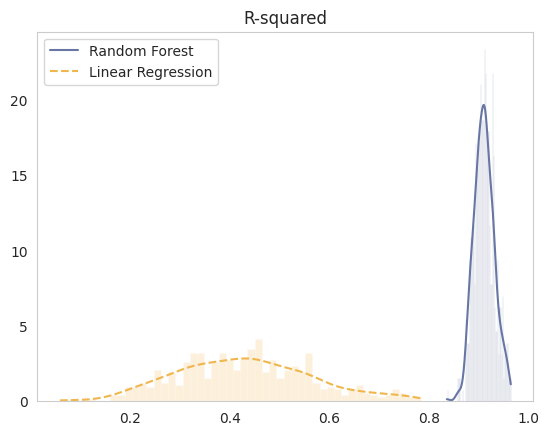

In [ ]:
plot_r_squared_comparative(comparison)

# 10. Which other factor can you can think of that should be in the model for excess returns? If you find daily or monthly data online, then redo the exercise above and interpret the findings for this factor parameter estimates and comment on how the previous parameter estimates have changed.

Momentum, in the context of financial markets, refers to the phenomenon where assets that have exhibited positive (or negative) performance in the recent past tend to continue experiencing similar performance in the near future. It suggests that assets with strong positive (or negative) returns are more likely to continue performing well (or poorly) in the short term. Momentum is observed across various asset classes and is considered a persistent market anomaly that can be used to identify potential trends and exploit return patterns.


Including momentum as an additional feature enhances the model's ability to capture short-term market dynamics and exploit potential return patterns.

In [48]:
# Get the data and clean it
momentum_factor =  pd.read_csv('/content/F-F_Momentum_Factor_daily.CSV', header =0)\
                .rename(columns = {'Unnamed: 0': 'Date'}).iloc[:-1,:]
momentum_factor["Date"] = pd.to_datetime(momentum_factor["Date"],  format="%Y%m%d")
momentum_factor = momentum_factor[momentum_factor['Date'] > '2010-01-01']

In [49]:
df_sf = pd.merge(ff,momentum_factor, on='Date',how='inner').rename(columns = {'Mom   ':'Mom'})
# # Merge dataframes based on date
df_sf = pd.merge(df_sf, returns, on = "Date", how = "inner", suffixes=["_FF", ""])

In [50]:
df_sf

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,Mom,A,AAL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,1.69,0.79,1.13,-0.17,0.21,0.000,0.59,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,0.31,-0.41,1.24,-0.19,0.19,0.000,0.64,-1.092242,10.724554,...,5.904160,-1.193039,0.389683,-1.195942,NaN,-0.342547,3.116528,-0.174548,3.465194,NaN
2,2010-01-06,0.13,-0.13,0.57,-0.05,0.20,0.000,-0.04,-0.355888,-4.231382,...,-1.320388,0.191854,0.860590,0.656682,NaN,-0.717456,-0.032311,-0.771667,8.338124,NaN
3,2010-01-07,0.40,0.25,0.98,-0.69,0.22,0.000,-0.85,-0.129771,2.904349,...,2.113141,-0.432224,-0.314641,1.300503,NaN,-0.028811,2.268120,-2.531778,10.616030,NaN
4,2010-01-08,0.33,0.32,0.01,0.22,-0.37,0.000,0.20,-0.032462,-1.926850,...,-0.719105,0.048148,-0.401992,0.000000,NaN,0.028811,-2.122823,-0.325557,-1.631961,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016,0.82,0.837650,1.590773,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016,0.73,-0.331202,0.286533,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016,-1.11,0.915649,2.612226,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016,-0.39,0.477010,0.832759,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


In [51]:
def prepare_data_ols_sf(df):
    ff_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA_FF","Mom"]
    X = df[ff_columns]
    X = sm.add_constant(X)
    return X

In [52]:
X_sf = prepare_data_ols_sf(df_sf)

In [54]:
def ols_estimation_sf(df, X, returns, forecast = False):
    """
    Function that estimates OLS-coefficients with the momentum variable
    """
    X_ = X.copy()
    beta_names = [f"beta_{var}" for var in X.columns]
    tvalue_names = [f"t_{var}" for var in X.columns]
    stocks = returns.columns[1:] # Excludes Date
    df_ols_results = pd.DataFrame(np.zeros((len(stocks), 16)), columns = ["stock"] + beta_names + tvalue_names + ["R2"])

    if forecast:
        X_ = X_[:-1].reset_index(drop = True)


    for i, stock in enumerate(stocks):
        # Get dependent variable y: excess returns of stock (X stays the same for every stock)
        y = df[stock] - df["RF_FF"]
        if forecast:
            y = y[1:].reset_index(drop = True)
        
        ols = sm.OLS(endog=y, exog=X_, missing = "drop")
        ols_results = ols.fit()
        coefs = ols_results.params
        t_stats = ols_results.tvalues
        r2 = ols_results.rsquared
        df_ols_results.iloc[i, 0] = stock
        df_ols_results.iloc[i, 1:] = np.concatenate([coefs,t_stats,[r2]])
    
    return df_ols_results


In [58]:
# OLS estimation with momentum
df_ols_results_sf = ols_estimation_sf(df_sf, X_sf, returns)
df_ols_results_sf.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,beta_Mom,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,t_Mom,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001131,0.999303,0.133721,0.160448,0.086172,0.032085,-0.029132,-0.086672,42.849905,1.956641,3.888389,2.049869,0.674791,-0.829595,0.432168
std,0.033016,0.216522,0.290544,0.465257,0.326534,0.425566,0.119642,0.927164,12.790779,5.918518,10.896569,5.342828,5.135746,3.577422,0.134291
min,-0.085912,0.440642,-0.631826,-1.167814,-1.242318,-1.371180,-0.504108,-2.759598,2.208367,-15.813806,-14.458130,-20.130052,-17.381770,-10.963231,0.059713
25%,-0.016846,0.846719,-0.091584,-0.153606,-0.063601,-0.194240,-0.092614,-0.701241,34.759919,-2.146944,-3.428314,-1.028969,-2.139382,-3.339436,0.332200
50%,-0.001762,1.001181,0.107401,0.090337,0.141425,0.068201,-0.014487,-0.080281,41.268361,2.247642,2.048556,2.373477,0.831512,-0.618256,0.430116
75%,0.012616,1.145504,0.328531,0.351125,0.324452,0.322828,0.045718,0.532542,50.628420,6.415943,7.235044,6.093665,3.920541,1.694676,0.524681
max,0.316349,1.676813,1.379132,1.805293,0.872822,1.039229,0.427616,2.469410,83.351414,16.651302,47.396284,14.661703,14.637722,8.138656,0.784159


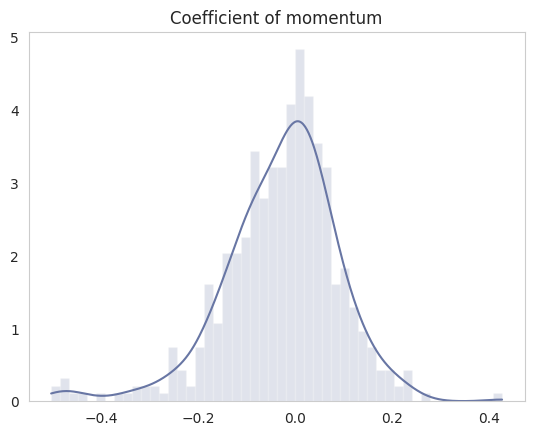

In [71]:
# Plot coefficient of momentum
vals = df_ols_results_sf["beta_Mom"]
d = stats.gaussian_kde(vals)
ind = np.linspace(min(vals),max(vals),500)
kdepdf = d.evaluate(ind)
plt.plot(ind, kdepdf, label="Kernel Density Estimator", color = DARK_COL)
plt.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
plt.grid(False)
plt.title("Coefficient of momentum")
plt.show()

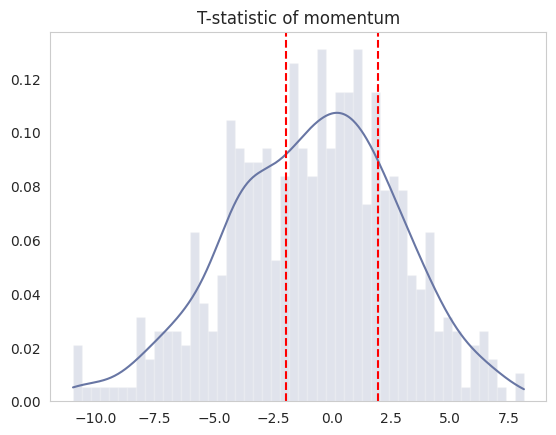

In [69]:
# Plot T-statistic of momentum
vals = df_ols_results_sf["t_Mom"]
d = stats.gaussian_kde(vals)
ind = np.linspace(min(vals),max(vals),500)
kdepdf = d.evaluate(ind)
plt.plot(ind, kdepdf, label="Kernel Density Estimator", color = DARK_COL)
plt.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
plt.axvline(-1.96, color = "red", ls = "--")
plt.axvline(1.96, color = "red", ls = "--")
plt.grid(False)
plt.title("T-statistic of momentum")
plt.show()

In [60]:
# Check when the momentum coefficient is statistically significant.
n_signif_pos = sum(df_ols_results_sf["t_Mom"] > 1.96)
n_signif_neg = sum(df_ols_results_sf["t_Mom"] < -1.96)
print(f"Stock with positive significant effect of momentum:  {n_signif_pos} ")
print(f"Stock with negative significant effect of momentum:  {n_signif_neg} ")

Stock with positive significant effect of momentum:  111 
Stock with negative significant effect of momentum:  179 


In [56]:
comparison = df_ols_results_sf.drop(['beta_Mom', 't_Mom'], axis = 1).describe() - df_ols_results.describe()

In [57]:
comparison

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,-0.000059,-0.000082,-0.006570,-0.017250,-0.003807,0.028235,-0.001474,0.076445,-0.129728,-0.612651,-0.049836,0.234465,0.002438
std,-0.000097,0.000480,-0.009278,-0.032948,0.001690,-0.001375,0.002477,0.031582,-0.206988,-1.368811,0.018593,-0.314861,-0.000414
min,0.001017,0.000574,-0.083445,-0.247778,-0.105286,0.185188,-0.016342,-0.139804,-0.312612,2.321351,-0.234847,0.529898,0.001069
25%,0.000026,-0.000615,0.006291,0.011142,-0.001093,0.021279,-0.003066,0.037928,0.181049,0.696239,0.033650,0.356287,0.001096
50%,0.000022,-0.000818,-0.001867,-0.007558,-0.007334,0.008997,-0.000344,0.023153,-0.276396,-0.271747,0.094592,0.145692,0.003729
75%,-0.000026,-0.000957,-0.008132,-0.037802,-0.000345,0.032009,-0.000136,0.025645,-0.236170,-1.378320,-0.075064,0.270979,0.002294
max,-0.008618,0.001187,0.021528,-0.001983,-0.015486,0.067446,0.011159,-0.016155,-0.671799,-5.042985,0.062143,0.314419,0.000863


In [74]:
X_sf.corr()

,const,Mkt-RF,SMB,HML,RMW,CMA_FF,Mom
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mkt-RF,NaN,1.000000,0.274513,0.020344,-0.285323,-0.220622,-0.107685
SMB,NaN,0.274513,1.000000,0.204015,-0.289571,-0.004451,-0.218014
HML,NaN,0.020344,0.204015,1.000000,0.225240,0.613827,-0.291786
RMW,NaN,-0.285323,-0.289571,0.225240,1.000000,0.251416,-0.032404
CMA_FF,NaN,-0.220622,-0.004451,0.613827,0.251416,1.000000,0.069537
Mom,NaN,-0.107685,-0.218014,-0.291786,-0.032404,0.069537,1.000000


**Comment:** The coefficient of momentum is low in absolute value, neighbouring zero. Furthermore we see that the distribution has fat tails, indicating a higher kurtosis. 

Concerning statistical significance, we observe that the coefficient of the momentum is significant in more than half of the stocks. That confirms the intuition that it is a relevant variable for explaining stock returns. Concerning the sign of the effect, we observe that it can be both negative and positive.

Since we added a new explanatory variable, it is natural that the other coefficients changed. We observe that a lot of coefficients reduced in size (even if the change is < 10e-2). The only case where a coefficient is being increased is in the case of CMA, where the coefficient and the t-statistic  increased on average. The correlation matrix indicates that the momentum is negatively correlated with most other explanatory variables expect for CMA. This difference explains why the coefficient of CMA shifts in the opposite direction than the other variables. 